# **Project - Fantasy Sports Clustering Analysis**


## **Objective**
-----------------------------

Conduct a cluster analysis on past season performance data of English Premier League players for OnSports fantasy sports platform, aiming to identify distinct player potential groups. This analysis will assist in establishing optimal player prices for the upcoming season, enhancing the platform's understanding of performance patterns and fantasy returns.

## What did I do

* Data Cleaning
* EDA
* Unsupervised PCA and cluster anaylsis including, K-means, K-medoids, HCA, DBSCAN and Gaussian mixture
* Cluster profilling
* Writing business recommendations based on the insignts derived from the PCA and clustering.

--------------------------
## **Data Description**
--------------------------

- **Player_Name:** Name of the player.
- **Club:** Club in which the player plays.
- **Position:** Position in which the player plays.
- **Goals_Scored:** Number of goals scored by the player in the previous season.
- **Assists:** Number of passes made by the player leading to goals in the previous season.
- **Total_Points:** Total number of fantasy points scored by the player in the previous season.
- **Minutes:** Number of minutes played by the player in the previous season.
- **Goals_Conceded:** Number of goals conceded by the player in the previous season.
- **Creativity:** A score, computed using a range of stats, that assesses player performance in terms of producing goalscoring opportunities for other players.
- **Influence:** A score, computed using a range of stats, that evaluates a player's impact on a match, taking into account actions that could directly or indirectly affect the match outcome.
- **Threat:** A score, computed using a range of stats, that gauges players who are most likely to score goals.
- **Bonus:** Total bonus points received. The three best performing players in each match receive additional bonus points based on a score computed using a range of stats. 3 points are awarded to the highest scoring player, 2 to the second best, and 1 to the third.
- **Clean_Sheets:** Number of matches without conceding a goal in the previous season.

## **Importing the necessary libraries**

In [40]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# To compute distances
from scipy.spatial.distance import cdist, pdist

# To perform K-Means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# To import K-Medoids
from sklearn_extra.cluster import KMedoids

# To import DBSCAN and Gaussian Mixture
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# To perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Calling the dataset
data = pd.read_csv("fpl_data.csv")

In [3]:
data.shape

(476, 13)

* The dataset has 476 rows and 13 columns.

In [4]:
# Viewing 10 random rows of the data
data.sample(10, random_state = 1)

,Player_Name,Club,Position,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets
441,Mark Noble,West Ham United,Midfielder,0,0,27,701,15,88.6,80.4,7,0,0
363,Sean Longstaff,Newcastle United,Midfielder,0,1,41,1405,26,182.8,179.2,148,1,2
31,Anwar El Ghazi,Aston Villa,Midfielder,10,0,111,1604,22,426.1,500.4,726,13,5
132,Olivier Giroud,Chelsea,Forward,4,0,47,740,5,112.0,161.4,403,6,4
90,Chris Wood,Burnley,Forward,12,3,138,2741,43,323.2,595.8,1129,16,9
249,Vontae Daley-Campbell,Leicester City,Defender,0,0,0,0,0,0.0,0.0,0,0,0
65,Danny Welbeck,Brighton and Hove Albion,Forward,6,4,89,1541,18,269.7,319.8,595,15,6
445,Ryan Fredericks,West Ham United,Defender,1,1,28,564,9,166.8,155.2,96,0,1
117,Christian Pulisic,Chelsea,Midfielder,4,3,82,1731,21,378.8,361.4,724,3,7
415,Ryan Sessegnon,Tottenham Hotspurs,Defender,0,0,0,0,0,0.0,0.0,0,0,0


**Observations:**

- The data has players from various clubs.
- There seem to be a lot of players playing in the midfield.
- Some players have played less or zero minutes in the previous season and so they have scored few or zero fantasy points, respectively.

In [5]:
# Copying the data to another variable to avoid any changes to original data
df = data.copy()

In [7]:
# Checking datatypes and number of non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Player_Name     476 non-null    object 
 1   Club            476 non-null    object 
 2   Position        476 non-null    object 
 3   Goals_Scored    476 non-null    int64  
 4   Assists         476 non-null    int64  
 5   Total_Points    476 non-null    int64  
 6   Minutes         476 non-null    int64  
 7   Goals_Conceded  476 non-null    int64  
 8   Creativity      476 non-null    float64
 9   Influence       476 non-null    float64
 10  Threat          476 non-null    int64  
 11  Bonus           476 non-null    int64  
 12  Clean_Sheets    476 non-null    int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 48.5+ KB


- Player_Name, Club, and Position are categorical variables.
- All the other columns in the data are numeric in nature.

In [8]:
# Checking for duplicate values
df.duplicated().sum()

0

- There are no duplicate values in the data.

In [9]:
# Checking for missing values
df.isnull().sum()

Player_Name       0
Club              0
Position          0
Goals_Scored      0
Assists           0
Total_Points      0
Minutes           0
Goals_Conceded    0
Creativity        0
Influence         0
Threat            0
Bonus             0
Clean_Sheets      0
dtype: int64

- There are no missing values in the data.

## **Exploratory Data Analysis**

In [10]:
# Statistical summary of the data
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Player_Name,476,476,Alex Runnarsson,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Club,476,17,Arsenal,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,476,4,Midfielder,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goals_Scored,476.0,NaN,NaN,NaN,1.907563,3.455562,0.0,0.0,0.5,2.0,23.0
Assists,476.0,NaN,NaN,NaN,1.752101,2.708563,0.0,0.0,0.0,2.0,14.0
Total_Points,476.0,NaN,NaN,NaN,58.516807,51.293559,0.0,10.0,48.0,94.25,244.0
Minutes,476.0,NaN,NaN,NaN,1336.909664,1073.773995,0.0,268.75,1269.5,2256.25,3420.0
Goals_Conceded,476.0,NaN,NaN,NaN,19.157563,15.946171,0.0,4.0,18.0,31.0,68.0
Creativity,476.0,NaN,NaN,NaN,195.97605,251.478541,0.0,8.3,96.95,296.95,1414.9
Influence,476.0,NaN,NaN,NaN,294.617647,267.779681,0.0,46.5,233.1,499.5,1318.2


**Observations:**

- There are players from 17 clubs in the data.
- Most of the players in the data play in midfield.
- The average number of minutes played is ~1350.
- Players scored an average of ~60 fantasy points in the previous season.
- More than 50% of the players in the data have scored one or no goals.
- 50% of the players in the data have assisted no goals.

### **Univariate Analysis**

In [11]:
# Function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize = (12, 7), kde = False, bins = None):
    
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12, 7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,      # Number of rows of the subplot grid = 2
        sharex = True,  # X-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize,
    )  # Creating the 2 subplots
    sns.boxplot(
        data = data, x = feature, ax = ax_box2, showmeans = True, color = "violet"
    )  # Boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2, bins = bins, palette = "winter"
    ) if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color = "green", linestyle = "--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color = "black", linestyle = "-"
    )  # Add median to the histogram

**`Goals_Scored`**

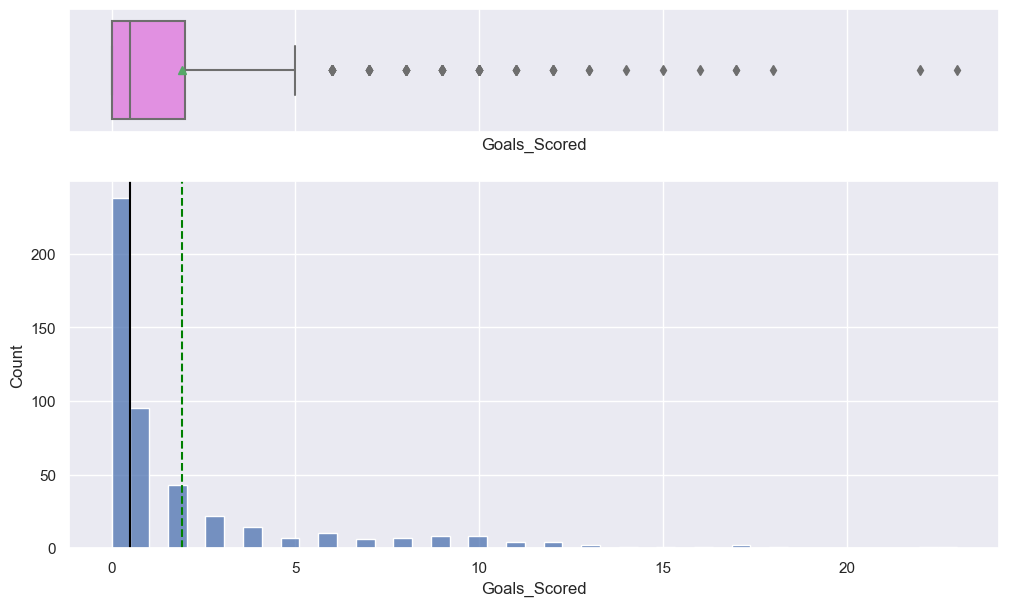

In [41]:
histogram_boxplot(df, 'Goals_Scored')

- The distribution is right-skewed and very few players have scored more than 15 goals.

**`Assists`**

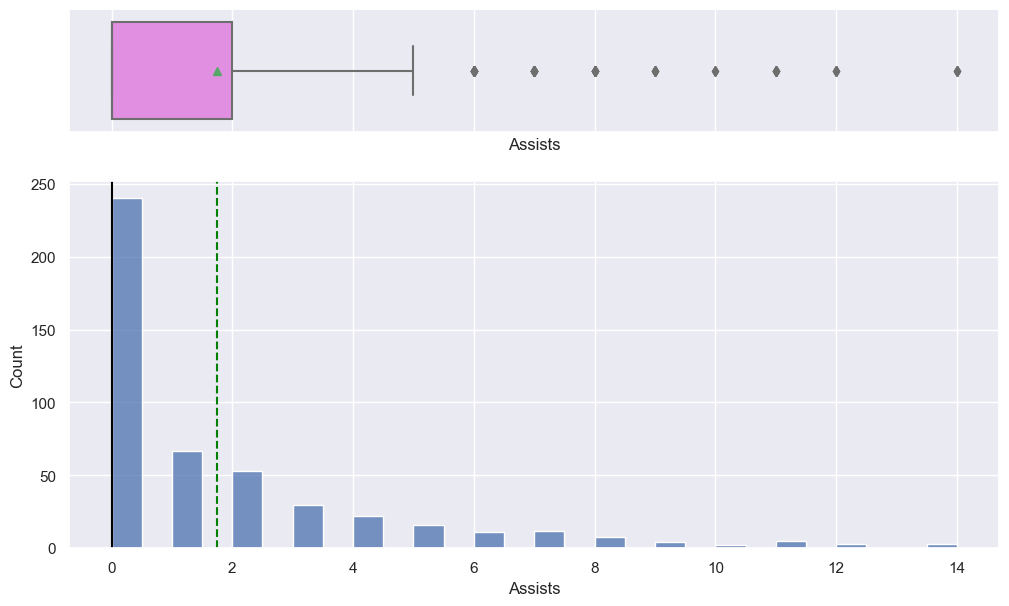

In [42]:
histogram_boxplot(df, 'Assists')

- The distribution is right-skewed and very few players have assisted more than 8 goals.

**`Goals_Conceded`**

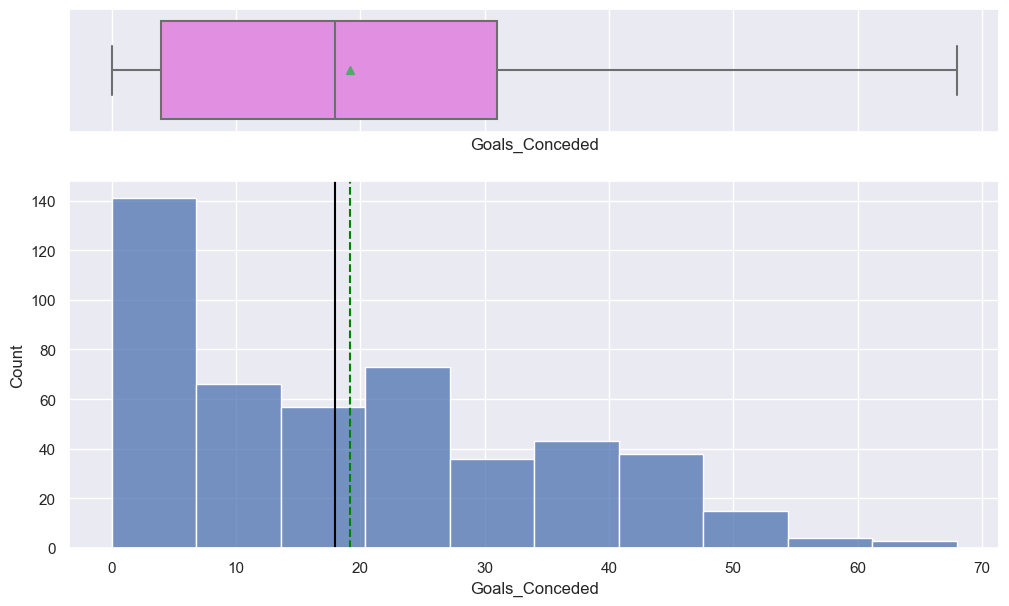

In [43]:
histogram_boxplot(df, 'Goals_Conceded');

- The distribution is slightly right-skewed and ~50% of the players have conceded 20 or less goals.

**`Clean_Sheets`**

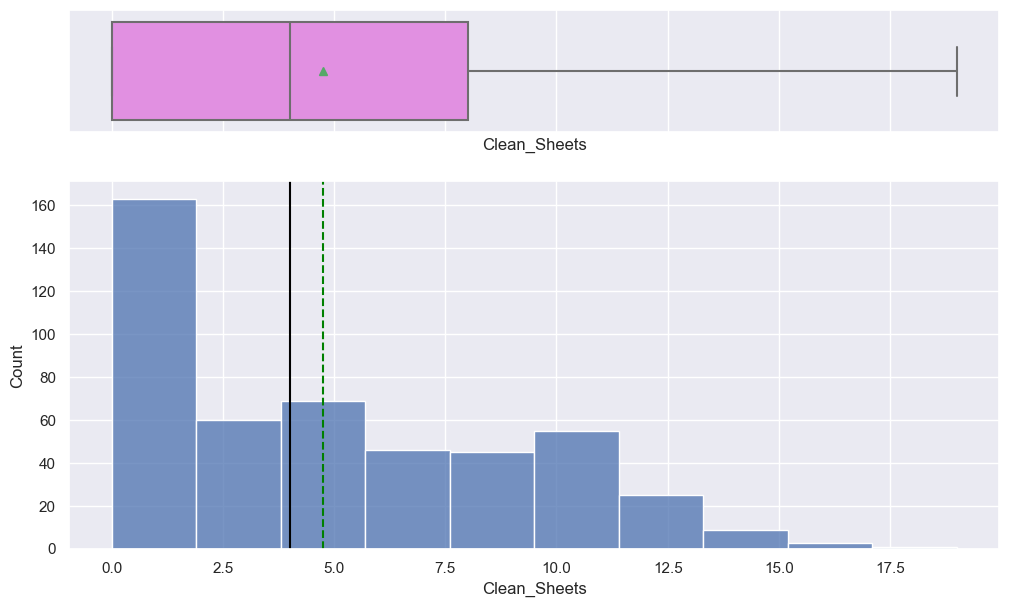

In [44]:
histogram_boxplot(df, 'Clean_Sheets')

- The distribution is slightly right-skewed and 50% of the players have kept 4 or less clean sheets.

**`Minutes`**

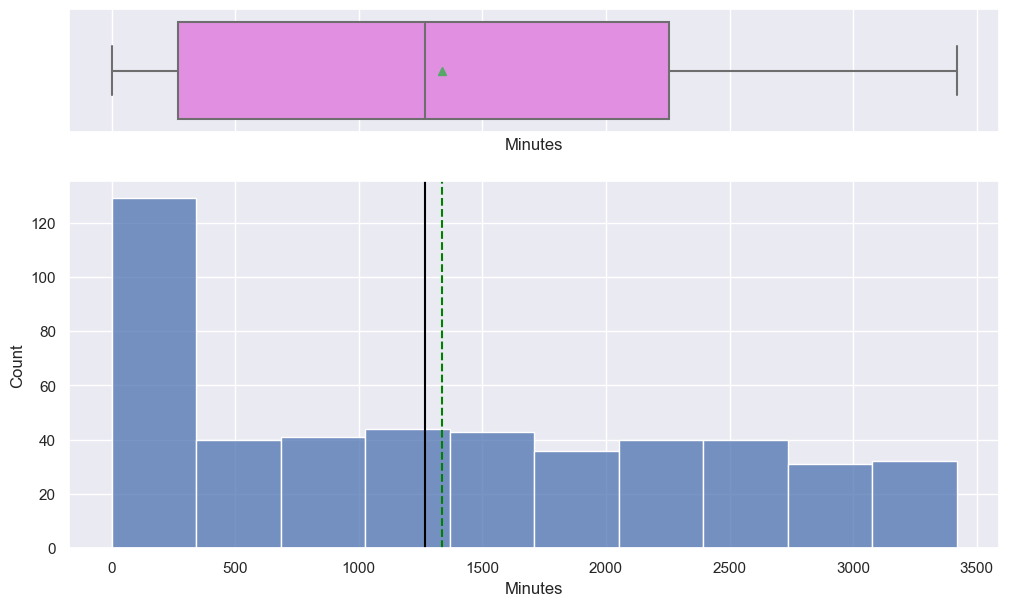

In [45]:
histogram_boxplot(df, 'Minutes')

- The distribution looks close to uniform, and 50% of the players have played ~1250 or more minutes.
- Many players did not play even a single minute of football last season.

**`Total_Points`**

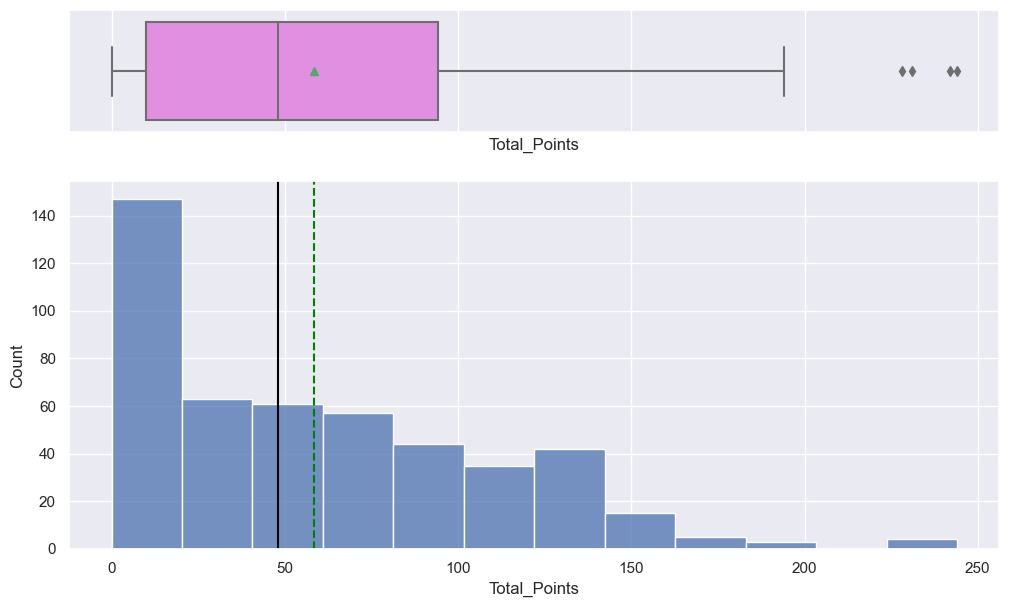

In [46]:
histogram_boxplot(df, 'Total_Points')

- The distribution is right-skewed, and more than 50% of the players have scored more than 50 fantasy points.
- Many players scored no fantasy points last season.
- There are a few outliers, suggesting that these players scored a lot more fantasy points than the others.

**`Creativity`**

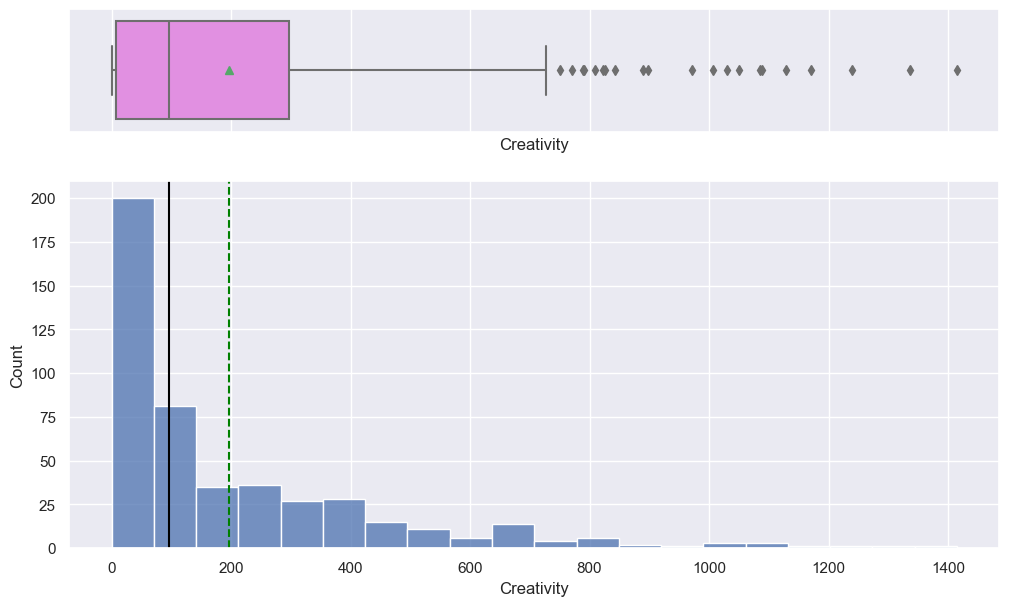

In [47]:
histogram_boxplot(df, 'Creativity')

- The distribution is right-skewed and few players have a creativity score of more than 500.

**`Influence`**

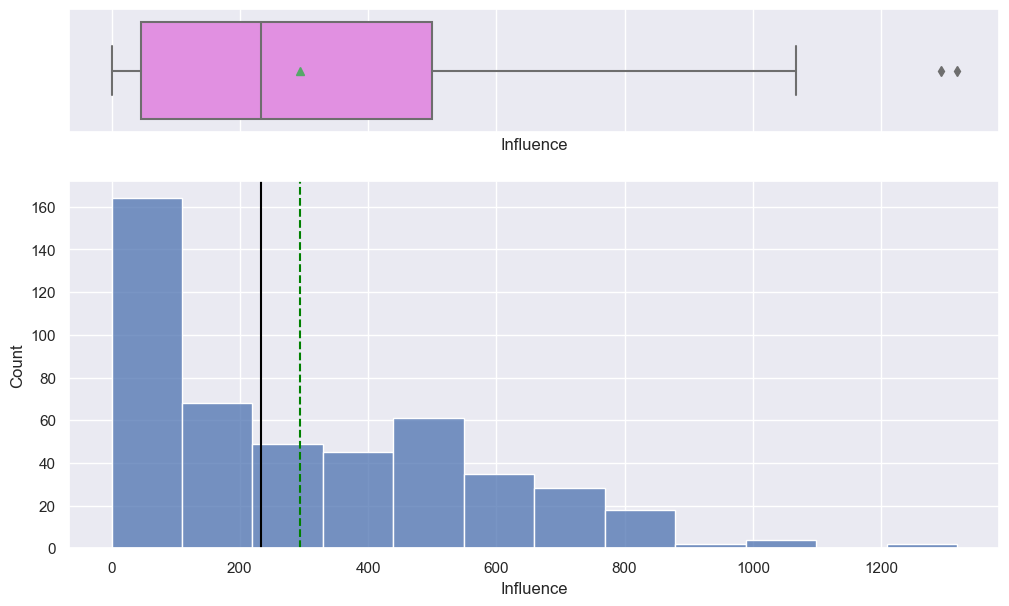

In [48]:
histogram_boxplot(df, 'Influence')

- The distribution is right-skewed and few players have a influence score of more than 800.

**`Threat`**

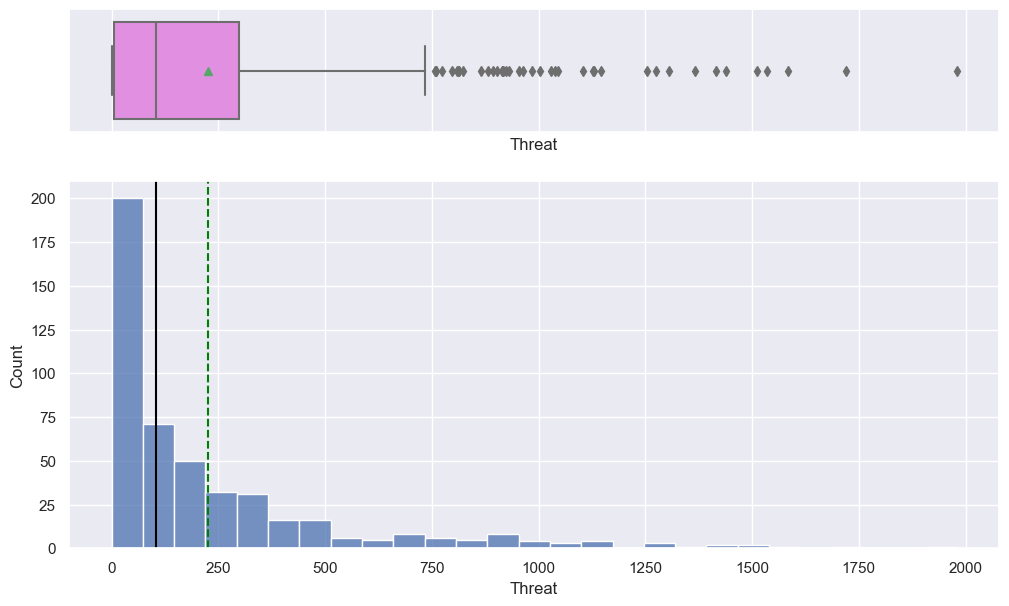

In [49]:
histogram_boxplot(df, 'Threat')

- The distribution is right-skewed and few players have a threat score of more than 500.

**`Bonus`**

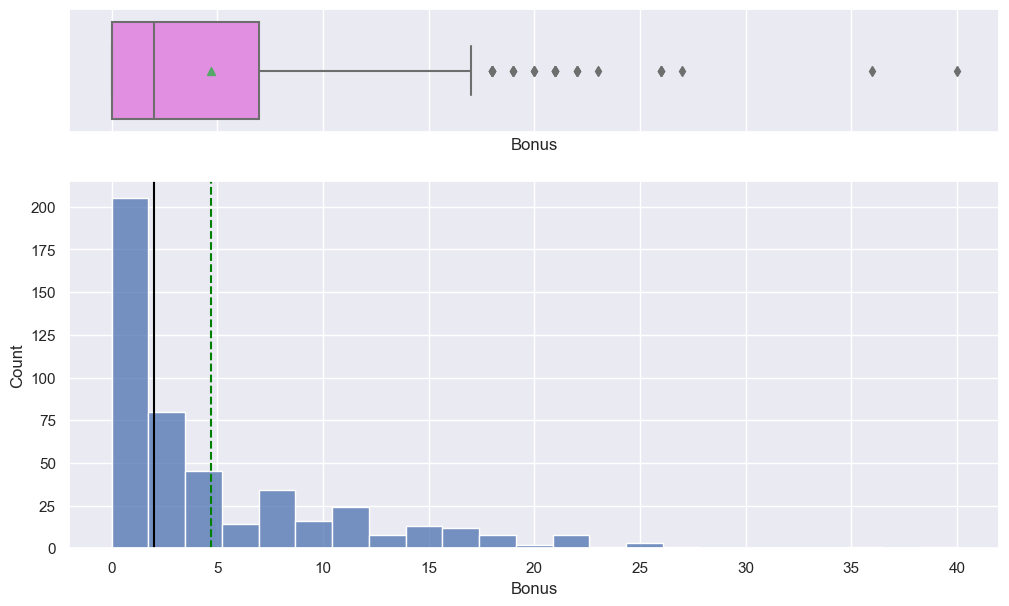

In [50]:
histogram_boxplot(df, 'Bonus')

- The distribution is right-skewed and very few players received more than 20 bonus fantasy points last season.

In [51]:
# Function to create labeled barplots


def labeled_barplot(data, feature, perc = False, n = None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # Length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize = (count + 1, 5))
    else:
        plt.figure(figsize = (n + 1, 5))

    plt.xticks(rotation = 90, fontsize = 15)
    ax = sns.countplot(
        data = data,
        x = feature,
        palette = "Paired",
        order = data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )                       # Percentage of each class of the category
        else:
            label = p.get_height()  # Count of each level of the category

        x = p.get_x() + p.get_width() / 2  # Width of the plot
        y = p.get_height()                 # Height of the plot

        ax.annotate(
            label,
            (x, y),
            ha = "center",
            va = "center",
            size = 12,
            xytext = (0, 5),
            textcoords = "offset points",
        )  # Annotate the percentage

    plt.show()  # Show the plot

**`Club`**

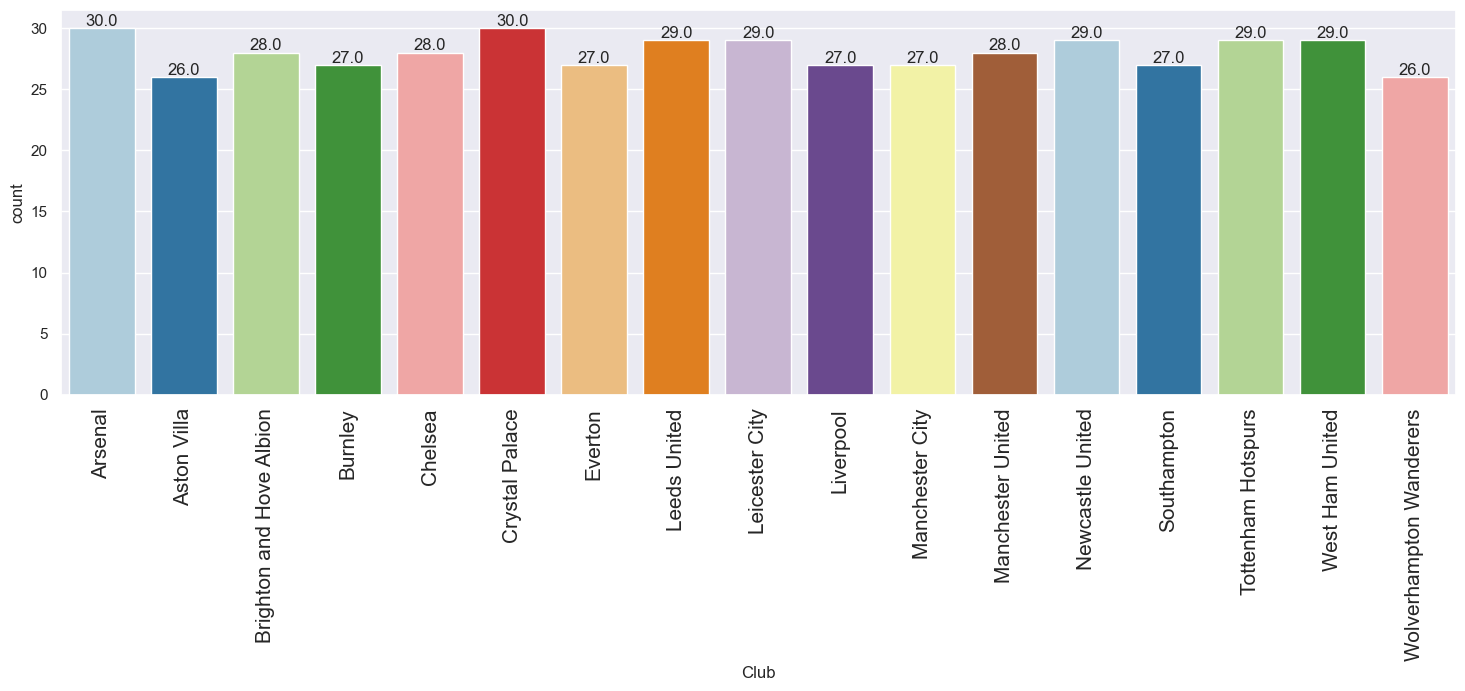

In [52]:
labeled_barplot(df, 'Club')

- The number of players in each club is almost uniformly distributed.
- All the clubs have at least 26 players.

**`Position`**

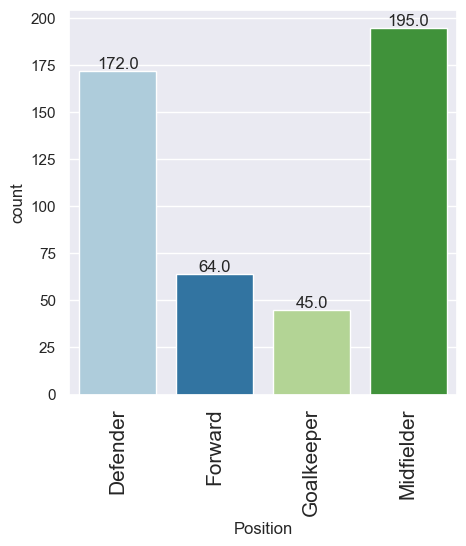

In [53]:
labeled_barplot(df, 'Position')

- The number of midfielders in the data is more than four times the number of goalkeepers.
    - This makes sense as a team can only play one goalkeeper in a match, so it doesn't make sense to have too many goalkeepers in the squad.
- The number of defenders in the data is nearly 3 times the number of forwards.
    - This has more to do with the formation in which the teams prefer to play nowadays.
    - Most teams tend to have 1 or 2 forwards only.

### **Bivariate Analysis**

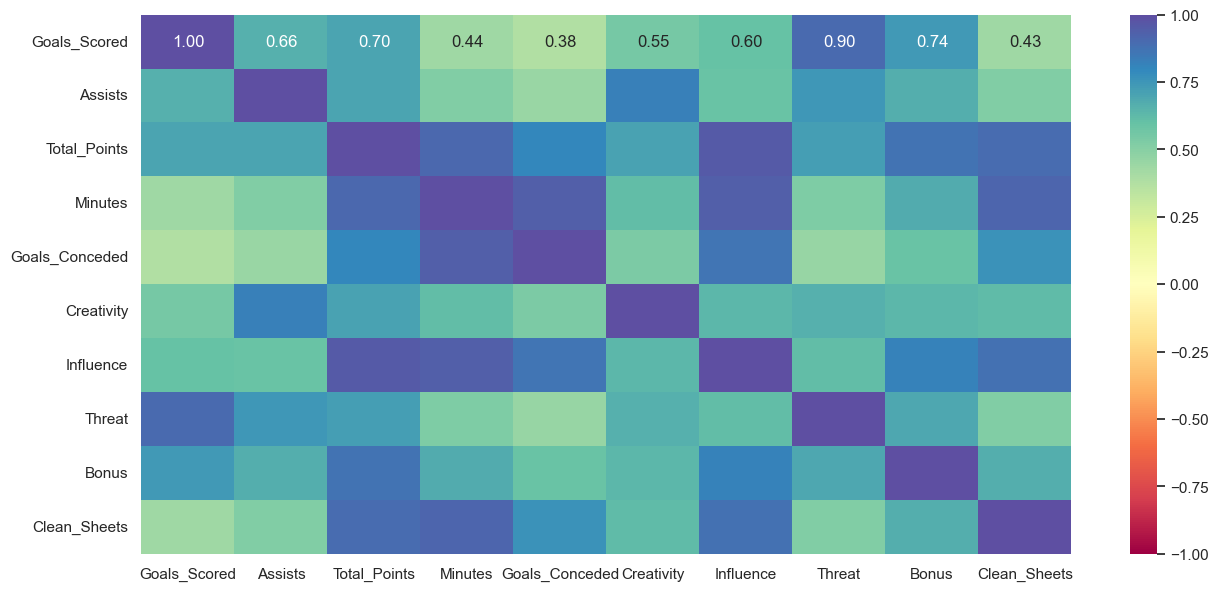

In [54]:
# Correlation check
cols_list = df.select_dtypes(include = np.number).columns.tolist()

plt.figure(figsize = (15, 7))

sns.heatmap(
    df[cols_list].corr(), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral"
)

plt.show()

**Observations:**

- Many variables show a high correlation with each other.

- The number of goals scored by a player and the threat score of the player is highly correlated.
    - This makes sense as the threat score gauges a player's goalscoring potential.

- Influence score is highly correlated with the total fantasy points scored and the number of minutes played by a player.
    -  This makes sense as these players have a higher impact on the game's outcome, so they tend to play for long each game and score more fantasy points.

**Checking players from which team have scored the most fantasy points on average.**

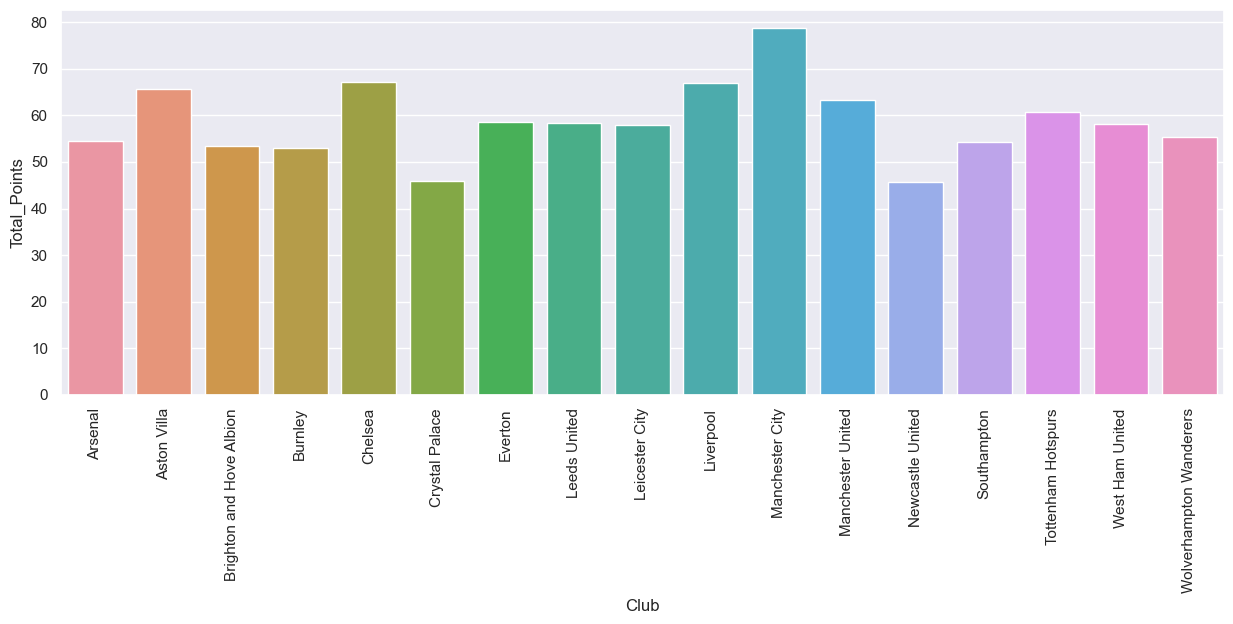

In [55]:
plt.figure(figsize = (15,5))
sns.barplot(data = df, x = 'Club', y = 'Total_Points', ci = False)
plt.xticks(rotation = 90)
plt.show()

- Looks like it is favorable to keep players from Manchester City in a fantasy team as they tend to score more fantasy points on average.

**Checking players in which positions tend to score more fantasy points on average.**

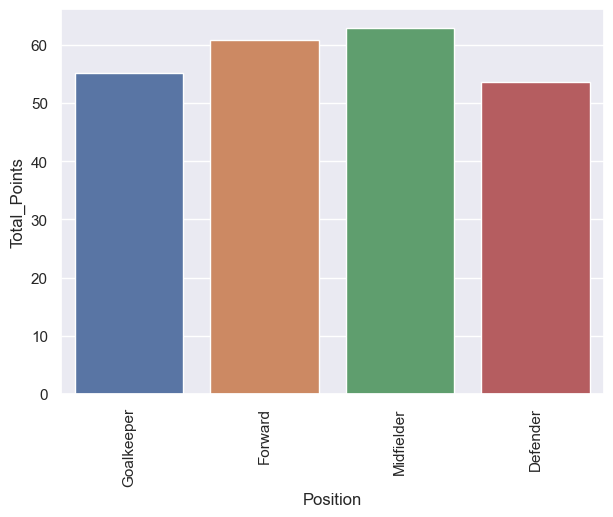

In [56]:
plt.figure(figsize = (7, 5))
sns.barplot(data = df, x = 'Position', y = 'Total_Points', ci = False)
plt.xticks(rotation = 90)
plt.show()

- Midfielders tend to fetch the most number of points for fantasy managers on average.

**checking the total number of minutes played, on average, across different positions.**

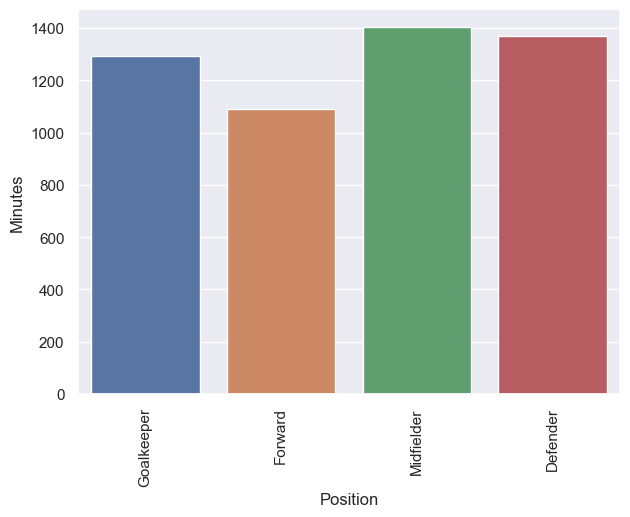

In [57]:
plt.figure(figsize = (7, 5))
sns.barplot(data = df, x = 'Position', y = 'Minutes', ci = False)
plt.xticks(rotation = 90)
plt.show()

- Players in the midfield and defense tend to play more minutes on average than forwards and goalkeepers.

**Checking which team's players have secured the most bonus points, on average, last season.**

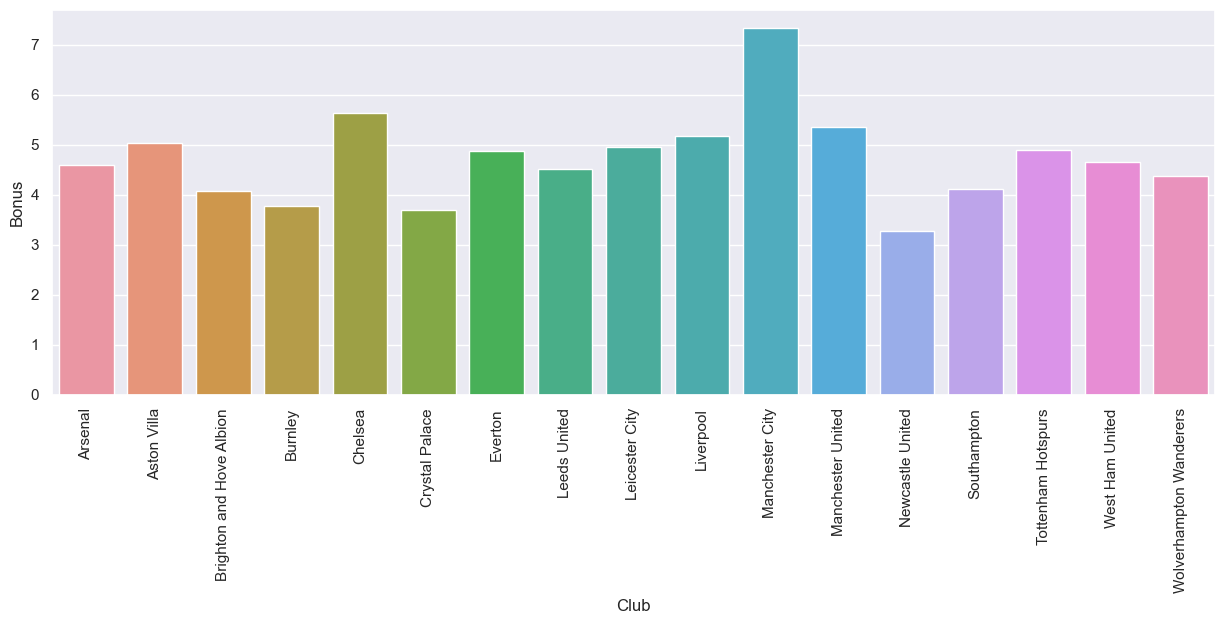

In [58]:
plt.figure(figsize = (15, 5))
sns.barplot(data = df, x = 'Club', y = 'Bonus', ci = False)
plt.xticks(rotation = 90)
plt.show()

- It's Manchester City again! The players of this club seem to be great fantasy picks.

**Checking which players scored the most fantasy points last season for different positions of play.**

In [59]:
pos_list = df.Position.unique().tolist()
best_df = pd.DataFrame()

for pos in pos_list:
    df_aux = df[df.Position == pos]
    best_df = best_df.append(df_aux[df_aux.Total_Points == df_aux.Total_Points.max()][['Player_Name', 'Club', 'Position', 'Total_Points']])

best_df

AttributeError: 'DataFrame' object has no attribute 'append'

- No Manchester City players here! That's surprising.

**Getting the top 10 players with the most fantasy points last season for different positions of play.**

In [60]:
best10_df = pd.DataFrame()

for pos in pos_list:
    df_aux = df[df.Position == pos]
    best10_df = best10_df.append(df_aux.sort_values('Total_Points', ascending = False).reset_index(drop = True).loc[:10, ['Player_Name', 'Club', 'Position', 'Total_Points']])

best10_df

AttributeError: 'DataFrame' object has no attribute 'append'

- Most of the top 10 players across different positions are from Manchester City and Liverpool.

### **Checking Outliers**

- Let's plot the boxplots of all numerical columns to check for outliers.

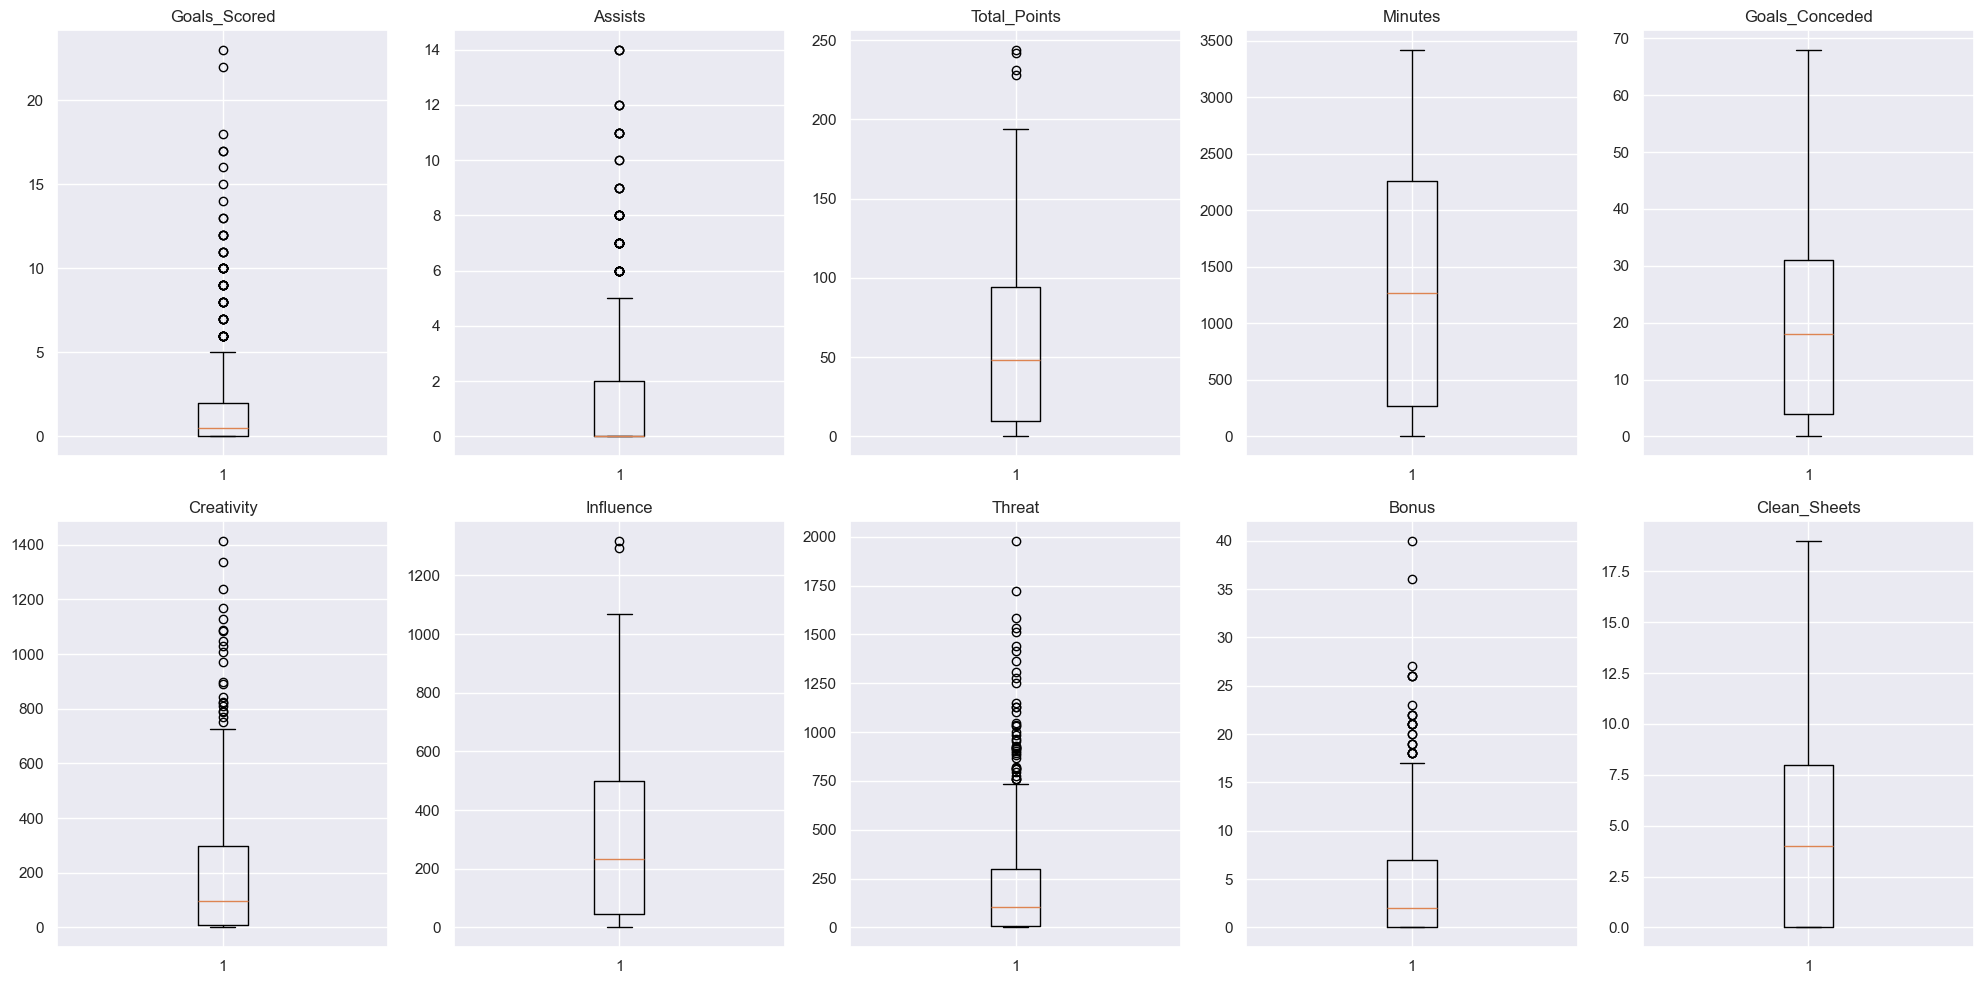

In [61]:
plt.figure(figsize = (20, 10))

numeric_columns = df.select_dtypes(include = np.number).columns.tolist()

for i, variable in enumerate(numeric_columns):
    
    plt.subplot(2, 5, i + 1)
    
    plt.boxplot(df[variable], whis = 1.5)
    
    plt.tight_layout()
    
    plt.title(variable)

plt.show()

- There are some outliers in the data.
- We will not treat them as they are proper values.

## **Scaling**

In [62]:
# Scaling the data before clustering
scaler = StandardScaler()
subset = df.iloc[:, 3:].copy()
subset_scaled = scaler.fit_transform(subset)

In [63]:
# Creating a dataframe of the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns = subset.columns)

## **Applying PCA**

In [64]:
# Importing PCA
from sklearn.decomposition import PCA

# Defining the number of principal components to generate
n = subset.shape[1]                                                 # Storing the number of variables in the data

pca = PCA(n_components = n, random_state = 1)                       # Storing PCA function with n components

data_pca = pd.DataFrame(pca.fit_transform(subset_scaled_df ))       # Applying PCA on scaled data

# The percentage of variance explained by each principal component is stored
exp_var = (pca.explained_variance_ratio_)                       

## **K-Means Clustering**

In [72]:
k_means_df = data_pca.copy()

Number of Clusters: 1 	Average Distortion: 2.773037110097803
Number of Clusters: 2 	Average Distortion: 1.8635736785898265
Number of Clusters: 3 	Average Distortion: 1.5612774038101607
Number of Clusters: 4 	Average Distortion: 1.3557368359611879
Number of Clusters: 5 	Average Distortion: 1.293154169974169
Number of Clusters: 6 	Average Distortion: 1.2242272213869858
Number of Clusters: 7 	Average Distortion: 1.1610308747131401
Number of Clusters: 8 	Average Distortion: 1.110336218225038
Number of Clusters: 9 	Average Distortion: 1.065953321120842
Number of Clusters: 10 	Average Distortion: 1.0174279276513463
Number of Clusters: 11 	Average Distortion: 1.0021422442688903
Number of Clusters: 12 	Average Distortion: 0.9834185498732175
Number of Clusters: 13 	Average Distortion: 0.9673126134780369
Number of Clusters: 14 	Average Distortion: 0.9475014323727127


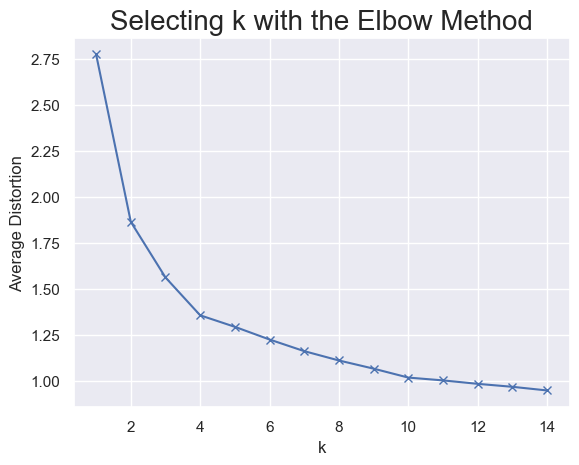

In [73]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters = k, random_state = 1)
    model.fit(data_pca)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis = 1))
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize = 20)
plt.show()

**Observations:**

- From the point at 4, the graph starts to move almost parallel to the X-axis. The K value corresponding to this point is the optimal K value or an optimal number of clusters.

**We will move ahead with k = 4.**

In [74]:
kmeans = KMeans(n_clusters = 4, random_state = 1)
kmeans.fit(k_means_df)

KMeans(n_clusters=4, random_state=1)

In [75]:
# Creating a copy of the original data
df1 = df.copy()

# Adding K-Means cluster labels to the K-Means and original dataframes
k_means_df["KM_segments"] = kmeans.labels_
df1["KM_segments"] = kmeans.labels_

### **Cluster Profiles**

In [71]:
km_cluster_profile = df1.groupby("KM_segments").mean()

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# Creating the "count_in_each_segment" feature in K-Means cluster profile

km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("KM_segments")["Total_Points"].count().values
)

In [42]:
km_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,count_in_each_segment
KM_segments,,,,,,,,,,,
0,1.460938,1.601562,55.648438,1389.453125,20.554688,187.653125,270.037500,218.117188,3.312500,4.687500,128
1,1.363636,1.878788,103.525253,2670.555556,37.525253,265.671717,579.185859,199.636364,7.676768,10.020202,99
2,9.147541,6.639344,141.557377,2446.704918,33.344262,617.495082,659.324590,880.540984,16.147541,9.213115,61
3,0.148936,0.202128,9.824468,238.750000,3.930851,28.171809,43.164894,30.244681,0.409574,0.558511,188


In [43]:
# Let's see the names of the players in each cluster
for cl in df1["KM_segments"].unique():
    print("In cluster {}, the following players are present:".format(cl))
    print(df1[df1["KM_segments"] == cl]["Player_Name"].unique())
    print()

In cluster 3, the following players are present:
['Alex Runnarsson' 'Cedric Soares' 'Edward Nketiah'
 'Gabriel Teodoro Martinelli Silva' 'Matt Macey' 'Miguel Azeez'
 'Pablo Mari' 'Reiss Nelson' 'Sead Kolasinac' 'Shkodran Mustafi'
 'Sokratis Papastathopoulos' 'William Saliba' 'Ahmed El Mohamady'
 'Carney Chukwuemeka' 'Conor Hourihane' 'Henri Lansbury' 'Jacob Ramsey'
 'Jaden Philogene-Bidace' 'Jose Peleteiro Romallo' 'Keinan Davis'
 'Kortney Hause' 'Marvelous Nakamba' 'Morgan Sanson' 'Orjan Nyland'
 'Wesley Moraes' 'Alireza Jahanbakhsh' 'Andi Zeqiri'
 'Bernardo Fernandes da Silva Junior' 'Davy Propper' 'Jakub Moder'
 'Jason Steele' 'Jayson Molumby' 'Jose Izquierdo' 'Percy Tau'
 'Reda Khadra' 'Anthony Driscoll-Glennon' 'Bailey Peacock-Farrell'
 'Dale Stephens' 'Jimmy Dunne' 'Joel Mumbongo' 'Josh Benson' 'Kevin Long'
 'Lewis Richardson' 'Phil Bardsley' 'Will Norris' 'Billy Gilmour'
 'Emerson Palmieri dos Santos' 'Faustino Anjorin' 'Fikayo Tomori'
 'Karlo Ziger' 'Kepa Arrizabalaga' 'Valenti

In [44]:
df1.groupby(["KM_segments", "Position"])['Player_Name'].count()

KM_segments  Position  
0            Defender      47
             Forward       16
             Goalkeeper     3
             Midfielder    62
1            Defender      50
             Goalkeeper    17
             Midfielder    32
2            Defender       5
             Forward       20
             Midfielder    36
3            Defender      70
             Forward       28
             Goalkeeper    25
             Midfielder    65
Name: Player_Name, dtype: int64

- Cluster 1 has no forwards, so it is likely to have players with more defensive duties in the team.
- Cluster 2 has no goalkeepers, so it is likely to have players with more offensive duties in the team.

**Let's plot the boxplot**

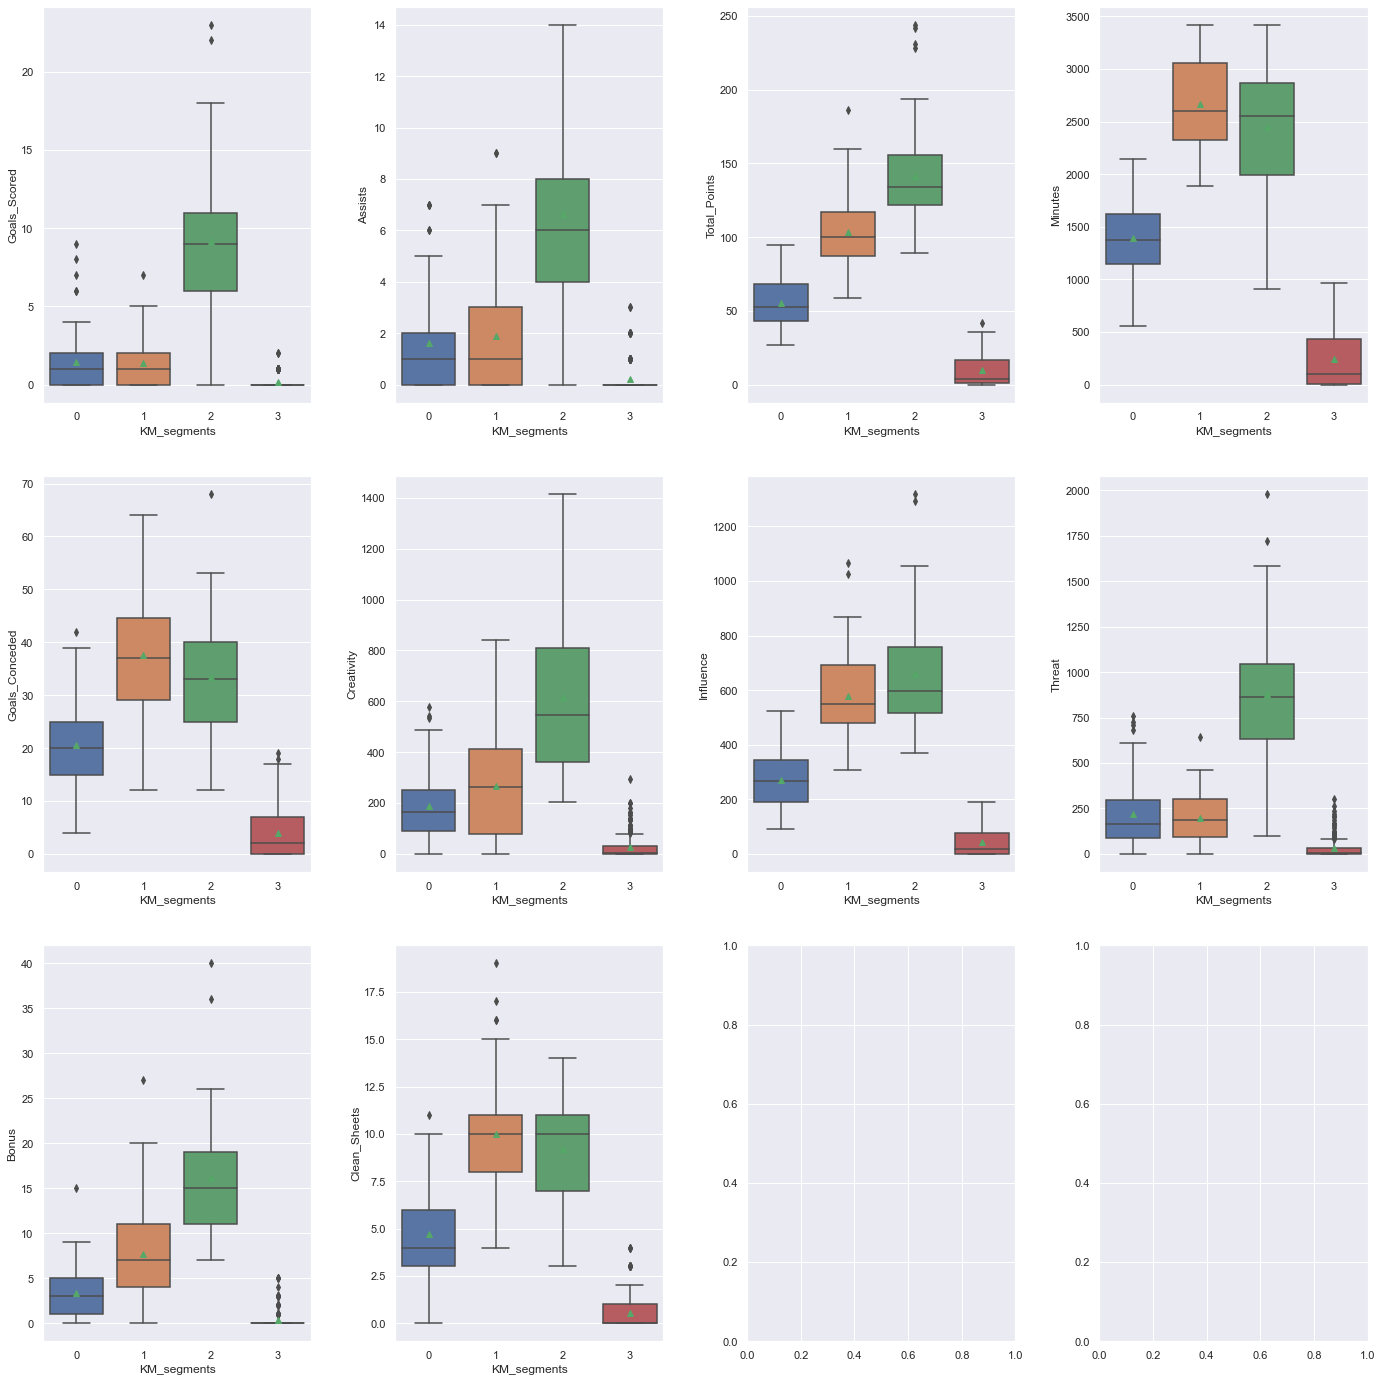

In [45]:
fig, axes = plt.subplots(3, 4, figsize = (20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 10:
            sns.boxplot(
                ax = axes[ii][jj],
                data = df1,
                y = df1.columns[3 + counter],
                x = "KM_segments", showmeans = True
            )
            counter = counter + 1

fig.tight_layout(pad = 3.0)

### **Characteristics of each cluster:**

- **Cluster 0**
    - There are 128 players in this cluster.
    - Most of the players in this cluster have a few goals and assists, and the total fantasy points scored in the previous season are low.
    - Most of the players in this cluster had a moderate game time, a low creativity score, a low influence score, and a moderate threat score.
    - Most of the players in this cluster received low bonus points.


- **Cluster 1**
    - There are 99 players in this cluster.
    - Most of the players in this cluster have a few goals and assists, and the total fantasy points scored in the previous season are moderate.
    - Most of the players in this cluster had a high game time, a moderate creativity score, a high influence score, and a moderate threat score.
    - Most of the players in this cluster received moderate bonus points.


- **Cluster 2**
    - There are 61 players in this cluster.
    - Most of the players in this cluster have a lot of goals and assists, and the total fantasy points scored in the previous season are high.
    - Most of the players in this cluster had a high game time, high creativity, influence, and scores.
    - Most of the players in this cluster received high bonus points.


- **Cluster 3**
    - There are 188 players in this cluster.
    - Players in this cluster, except a few, have no goals and assists and did not score any fantasy points scored in the previous season.
    - Most of the players in this cluster had a low game time, and low creativity, influence, and threat scores.
    - Players in this cluster, except a few, received no bonus points.

## **K-Medoids Clustering**

K-Medoids clustering is a robust algorithm that can handle non-linear clusters and is less sensitive to outliers compared to K-Means clustering.

In [47]:
k_med_df = data_pca.copy()

In [48]:
kmed = KMedoids(n_clusters = 4, random_state = 1) # Create K-Medoids with nclusters = 4
kmed.fit(k_med_df)

KMedoids(n_clusters=4, random_state=1)

In [49]:
# Creating a copy of the original data
df2 = df.copy()

# Add K-Medoids cluster labels to K-Medoids data
k_med_df["KMed_segments"] = kmed.labels_
# Add K-Medoids cluster labels to the whole data
df2["KMed_segments"] =  kmed.labels_

### **Cluster Profiling**

In [50]:
kmed_cluster_profile = df2.groupby("KMed_segments").mean()

In [51]:
kmed_cluster_profile["count_in_each_segment"] = (
    df2.groupby("KMed_segments")["Total_Points"].count().values
)

kmed_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,count_in_each_segment
KMed_segments,,,,,,,,,,,
0,7.512195,6.195122,133.243902,2452.243902,33.853659,602.902439,625.653659,745.402439,14.573171,9.231707,82
1,1.068966,1.091954,99.528736,2638.195402,36.632184,184.582759,575.818391,166.333333,6.988506,9.931034,87
2,1.338235,1.558824,51.073529,1270.051471,18.977941,180.458824,242.588235,203.102941,2.904412,4.205882,136
3,0.099415,0.111111,7.736842,193.187135,3.362573,18.979532,34.188304,22.608187,0.280702,0.385965,171


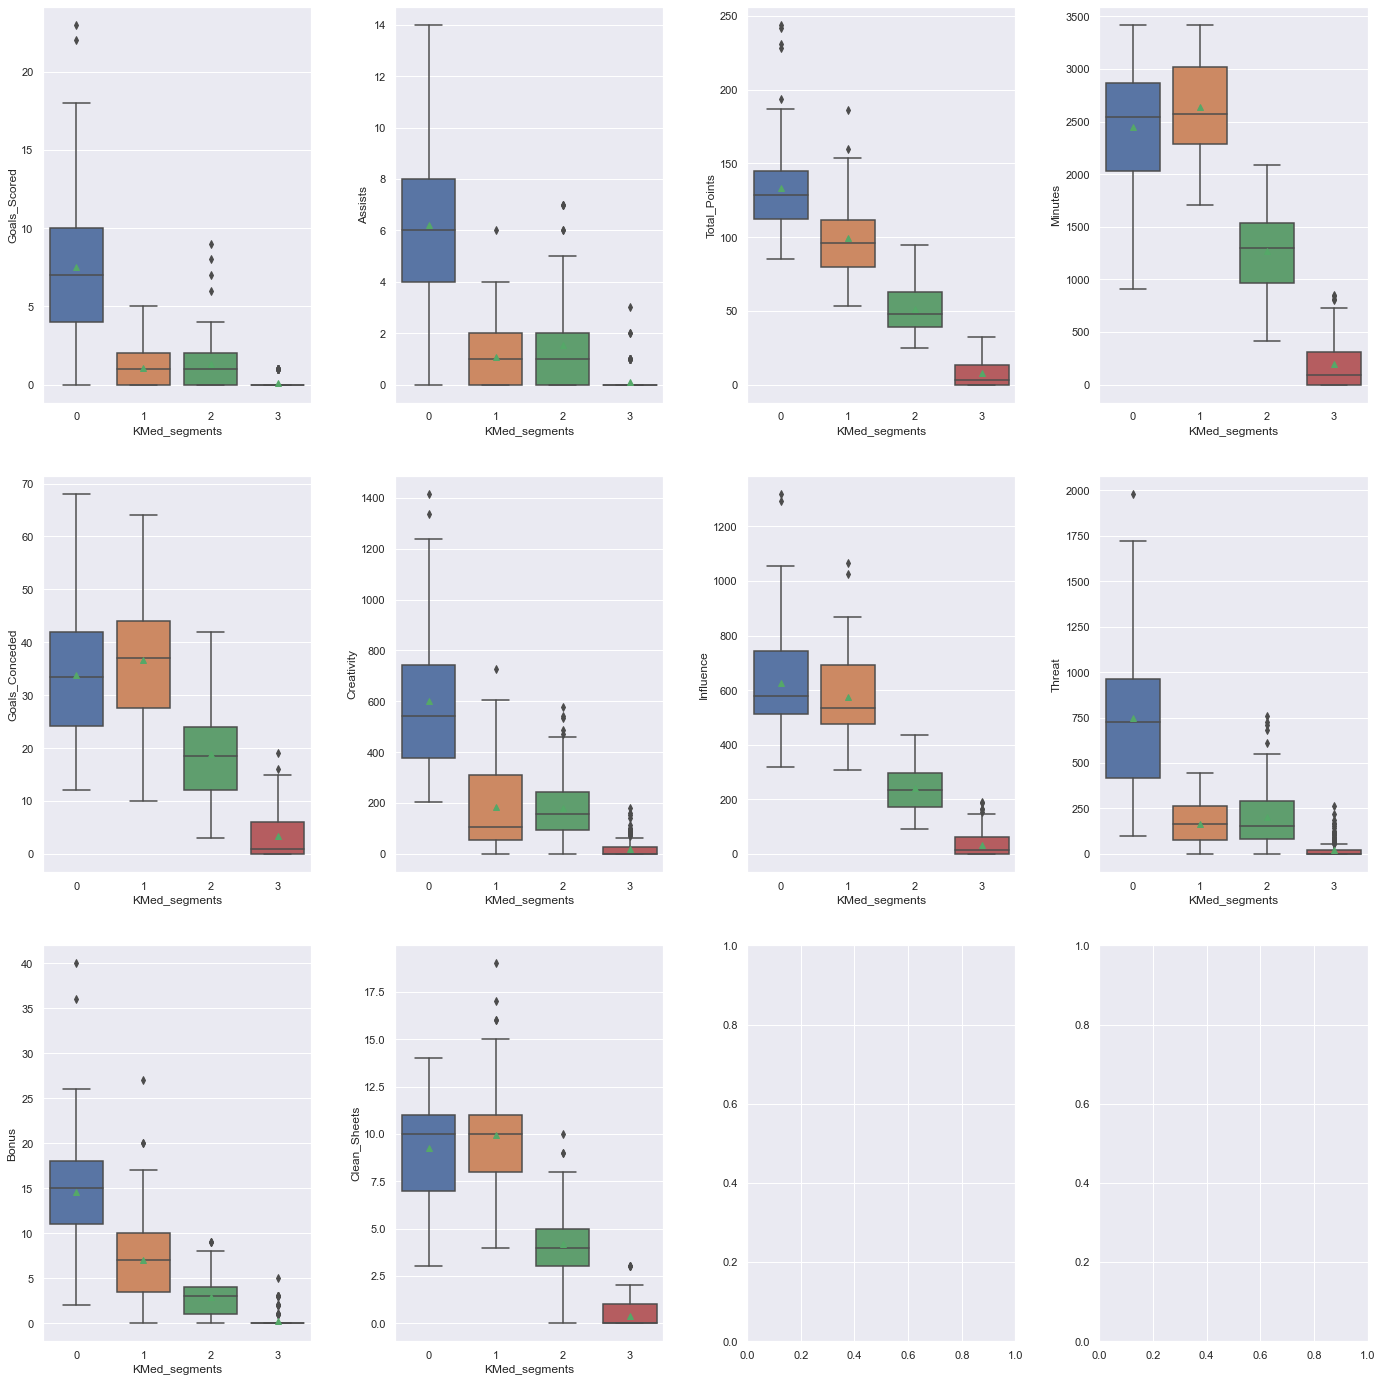

In [52]:
fig, axes = plt.subplots(3, 4, figsize = (20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 10:
            sns.boxplot(
                ax = axes[ii][jj],
                data = df2,
                y = df2.columns[3 + counter],
                x = "KMed_segments", showmeans = True
            )
            counter = counter + 1

fig.tight_layout(pad = 3.0)

### **Comparison of cluster profiles from K-Means and K-Medoids**


1. There is a difference in the distribution of each cluster in both algorithms. The cluster groups in K-Medoids are more evenly distributed since it uses a median which is less likely to get affected by the external data/outliers. 
2. The cluster profiles are the same for both algorithms, Cluster number is changing however the cluster profiles remain the same.

 ### **Characteristics of each cluster**
- **Cluster 0**
    - There are 82 players in this cluster.
    - Most of the players in this cluster have high goals and assists, and the total fantasy points scored in the previous season are high.
    - Most of the players in this cluster had a moderate game time with a high creativity score, high influence score, and a moderately high score.
    - Most of the players in this cluster received high bonus points.
    - Most of the players in this cluster received moderate clean sheets with an average of 9.5.
    


- **Cluster 1**
    - There are 87 players in this cluster.
    - Most of the players in this cluster have a few goals and assists, and the total fantasy points scored in the previous season are high.
    - Most of the players in this cluster had a high game time, a moderate creativity score, a high influence score, and a less threat score.
    - Most of the players in this cluster received moderate bonus points.


- **Cluster 2**
    - There are 136 players in this cluster.
    - Most of the players in this cluster have moderate goals and assists, and the total fantasy points scored in the previous season are moderate.
    - Most of the players in this cluster had a moderate game time, with low creativity, influence scores, and moderate threat scores.
    - Most of the players in this cluster received fewer bonus points.


- **Cluster 3**
    - There are 171 players in this cluster.
    - Players in this cluster, except a few, have no goals and assists and did not score any fantasy points scored in the previous season.
    - Most of the players in this cluster had a low game time, and low creativity, influence, and threat scores.
    - Players in this cluster, except a few, received no bonus points.

## **Hierarchical Clustering**

In [53]:
hc_df = data_pca.copy()

In [54]:
# List of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# List of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric = dm, method = lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
            
# Printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.8430175514228706.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7412041292261758.
Cophenetic correlation for Euclidean distance and average linkage is 0.8476499945585418.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8624581351067481.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8381223141111798.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8028394390632131.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8167064931302253.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8448497876639636.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8065008904132246.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6583135946489013.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7747800632434056.
Cophenetic co

**Here I explored different linkage methods with Euclidean distance only.**

In [55]:
# List of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hc_df, metric = "euclidean", method = lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm
        
# Printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.8430175514228706.
Cophenetic correlation for complete linkage is 0.7412041292261758.
Cophenetic correlation for average linkage is 0.8476499945585418.
Cophenetic correlation for centroid linkage is 0.8068296032280463.
Cophenetic correlation for ward linkage is 0.577773844586155.
Cophenetic correlation for weighted linkage is 0.8624581351067481.
****************************************************************************************************
Highest cophenetic correlation is 0.8624581351067481, which is obtained with weighted linkage.



**Viewing the dendrograms for the different linkage methods.**

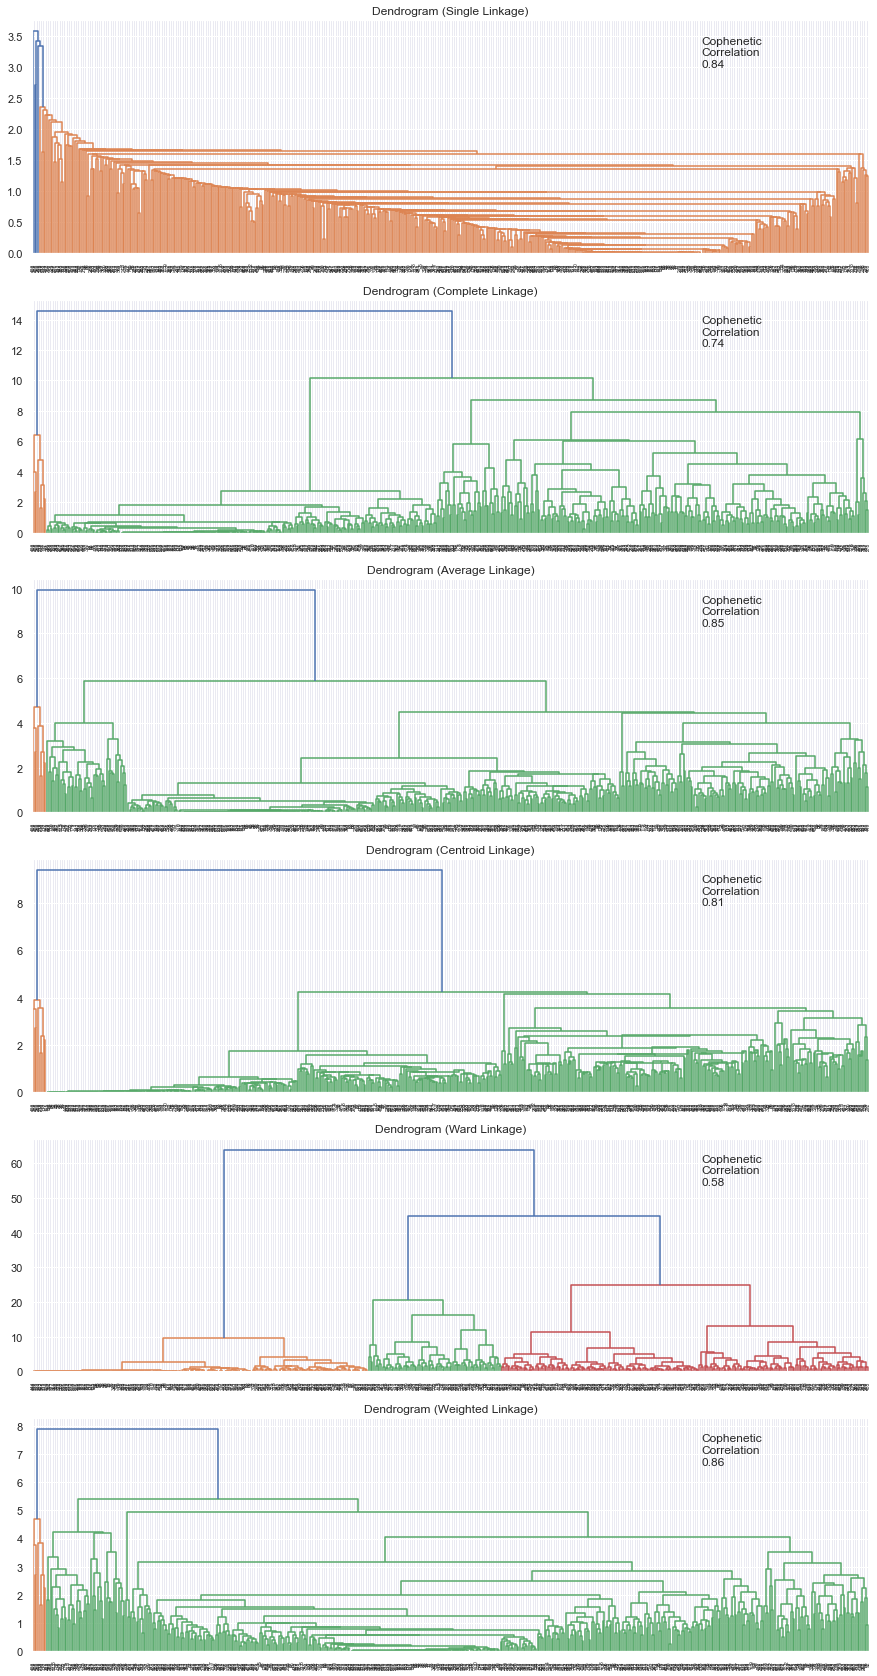

In [56]:
# List of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# Lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# To create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize = (15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric = "euclidean", method = method)

    dendrogram(Z, ax = axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [57]:
# Create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns = compare_cols)

df_cc = df_cc.sort_values(by = "Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
4,ward,0.577774
1,complete,0.741204
3,centroid,0.806830
0,single,0.843018
2,average,0.847650
5,weighted,0.862458


**Let's move ahead with 4 clusters, Euclidean distance, and average linkage as the sklearn implementation does not support weighted linkage.**

In [58]:
HCmodel = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "average")
HCmodel.fit(hc_df)

AgglomerativeClustering(linkage='average', n_clusters=4)

In [59]:
# Creating a copy of the original data
df3 = df.copy()

# Adding hierarchical cluster labels to the original and whole dataframes
hc_df["HC_segments"] = HCmodel.labels_
df3["HC_segments"] = HCmodel.labels_

### **Cluster Profiling**

In [60]:
hc_cluster_profile = df3.groupby("HC_segments").mean()

In [61]:
hc_cluster_profile["count_in_each_segment"] = (
    df3.groupby("HC_segments")["Total_Points"].count().values
)

In [62]:
hc_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,count_in_each_segment
HC_segments,,,,,,,,,,,
0,0.881517,1.139810,47.969194,1205.945498,17.580569,148.574408,249.536967,131.753555,3.293839,4.182464,422
1,16.800000,9.200000,189.000000,3033.200000,44.000000,494.340000,860.720000,1591.600000,21.800000,10.800000,5
2,8.565217,5.826087,129.391304,2238.934783,29.760870,543.273913,586.234783,861.739130,14.021739,8.739130,46
3,19.333333,13.000000,238.000000,3101.000000,37.000000,1041.300000,1221.000000,1294.666667,34.000000,12.666667,3


In [63]:
# Let's see the names of the players in each cluster
for cl in df3["HC_segments"].unique():
    print("In cluster {}, the following players are present:".format(cl))
    print(df3[df3["HC_segments"] == cl]["Player_Name"].unique())
    print()

In cluster 0, the following players are present:
['Alex Runnarsson' 'Bernd Leno' 'Calum Chambers' 'Cedric Soares'
 'Daniel Ceballos' 'David Luiz' 'Edward Nketiah' 'Emile Smith Rowe'
 'Gabriel Maghalaes' 'Gabriel Teodoro Martinelli Silva' 'Granit Xhaka'
 'Hector Bellerin' 'Kieran Tierney' 'Martin Odegaard' 'Matt Macey'
 'Miguel Azeez' 'Mohamed Naser El Sayed Elneny' 'Pablo Mari'
 'Reiss Nelson' 'Rob Holding' 'Sead Kolasinac' 'Shkodran Mustafi'
 'Sokratis Papastathopoulos' 'Thomas Partey' 'William Saliba'
 'Willian Borges Da Silva' 'Ahmed El Mohamady' 'Carney Chukwuemeka'
 'Conor Hourihane' 'Douglas Luiz Soares de Paulo' 'Emiliano Martinez'
 'Ezri Konsa Ngoyo' 'Henri Lansbury' 'Jacob Ramsey'
 'Jaden Philogene-Bidace' 'John McGinn' 'Jose Peleteiro Romallo'
 'Keinan Davis' 'Kortney Hause' 'Mahmoud Ahmed Ibrahim Hassan'
 'Marvelous Nakamba' 'Matt Targett' 'Matthew Cash' 'Morgan Sanson'
 'Orjan Nyland' 'Ross Barkley' 'Tyrone Mings' 'Wesley Moraes'
 'Aaron Connolly' 'Adam Lallana' 'Adam Webst

In [64]:
df3.groupby(["HC_segments", "Position"])['Player_Name'].count()

HC_segments  Position  
0            Defender      171
             Forward        43
             Goalkeeper     45
             Midfielder    163
1            Forward         4
             Midfielder      1
2            Defender        1
             Forward        16
             Midfielder     29
3            Forward         1
             Midfielder      2
Name: Player_Name, dtype: int64

**We see that most of the players have been grouped into one cluster, and there are two very sparse clusters. This clustering does not look good as the clusters do not have enough variability.**

**Using Ward linkage as it has more distinct and separated clusters (as seen from it's dendrogram before). 4 appears to be a good number of clusters from the dendrogram for Ward linkage.**

In [65]:
HCmodel = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward")
HCmodel.fit(hc_df)

AgglomerativeClustering(n_clusters=4)

In [66]:
# Creating a copy of the original data
df3 = df.copy()

# Adding hierarchical cluster labels to the HC algorithm and original dataframes
hc_df["HC_segments"] = HCmodel.labels_
df3["HC_segments"] = HCmodel.labels_

### **Cluster Profiling**

In [67]:
hc_cluster_profile = df3.groupby("HC_segments").mean()

In [68]:
hc_cluster_profile["count_in_each_segment"] = (
    df3.groupby("HC_segments")["Total_Points"].count().values
)

In [69]:
hc_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,count_in_each_segment
HC_segments,,,,,,,,,,,
0,9.925926,6.537037,140.944444,2360.370370,31.481481,566.411111,646.914815,953.370370,15.851852,9.148148,54
1,1.482456,1.640351,54.315789,1364.087719,20.789474,185.628947,262.635088,224.508772,3.070175,4.429825,114
2,1.478632,2.102564,103.239316,2614.273504,36.470085,304.364103,570.646154,206.205128,8.136752,9.811966,117
3,0.157068,0.251309,10.324607,248.863874,4.094241,31.026702,45.018848,30.785340,0.460733,0.586387,191


In [70]:
# Let's see the names of the players in each cluster
for cl in df3["HC_segments"].unique():
    print("In cluster {}, the following players are present:".format(cl))
    print(df3[df3["HC_segments"] == cl]["Player_Name"].unique())
    print()

In cluster 3, the following players are present:
['Alex Runnarsson' 'Calum Chambers' 'Cedric Soares' 'Edward Nketiah'
 'Martin Odegaard' 'Matt Macey' 'Miguel Azeez' 'Pablo Mari' 'Reiss Nelson'
 'Sead Kolasinac' 'Shkodran Mustafi' 'Sokratis Papastathopoulos'
 'William Saliba' 'Ahmed El Mohamady' 'Carney Chukwuemeka'
 'Conor Hourihane' 'Henri Lansbury' 'Jacob Ramsey'
 'Jaden Philogene-Bidace' 'Jose Peleteiro Romallo' 'Keinan Davis'
 'Kortney Hause' 'Marvelous Nakamba' 'Morgan Sanson' 'Orjan Nyland'
 'Wesley Moraes' 'Alireza Jahanbakhsh' 'Andi Zeqiri'
 'Bernardo Fernandes da Silva Junior' 'Davy Propper' 'Jakub Moder'
 'Jason Steele' 'Jayson Molumby' 'Jose Izquierdo' 'Percy Tau'
 'Reda Khadra' 'Tariq Lamptey' 'Anthony Driscoll-Glennon'
 'Bailey Peacock-Farrell' 'Dale Stephens' 'Jimmy Dunne' 'Joel Mumbongo'
 'Josh Benson' 'Kevin Long' 'Lewis Richardson' 'Phil Bardsley'
 'Will Norris' 'Billy Gilmour' 'Emerson Palmieri dos Santos'
 'Faustino Anjorin' 'Fikayo Tomori' 'Karlo Ziger' 'Kepa Arriza

In [71]:
df3.groupby(["HC_segments", "Position"])['Player_Name'].count()

HC_segments  Position  
0            Defender       1
             Forward       21
             Midfielder    32
1            Defender      38
             Forward       14
             Goalkeeper     3
             Midfielder    59
2            Defender      61
             Goalkeeper    17
             Midfielder    39
3            Defender      72
             Forward       29
             Goalkeeper    25
             Midfielder    65
Name: Player_Name, dtype: int64

- Cluster 0 has no goalkeepers, so it is likely to have players with more offensive duties in the team.
- Cluster 2 has no forwards, so it is likely to have players with more defensive duties in the team.

**Checking the cluster profiles.**

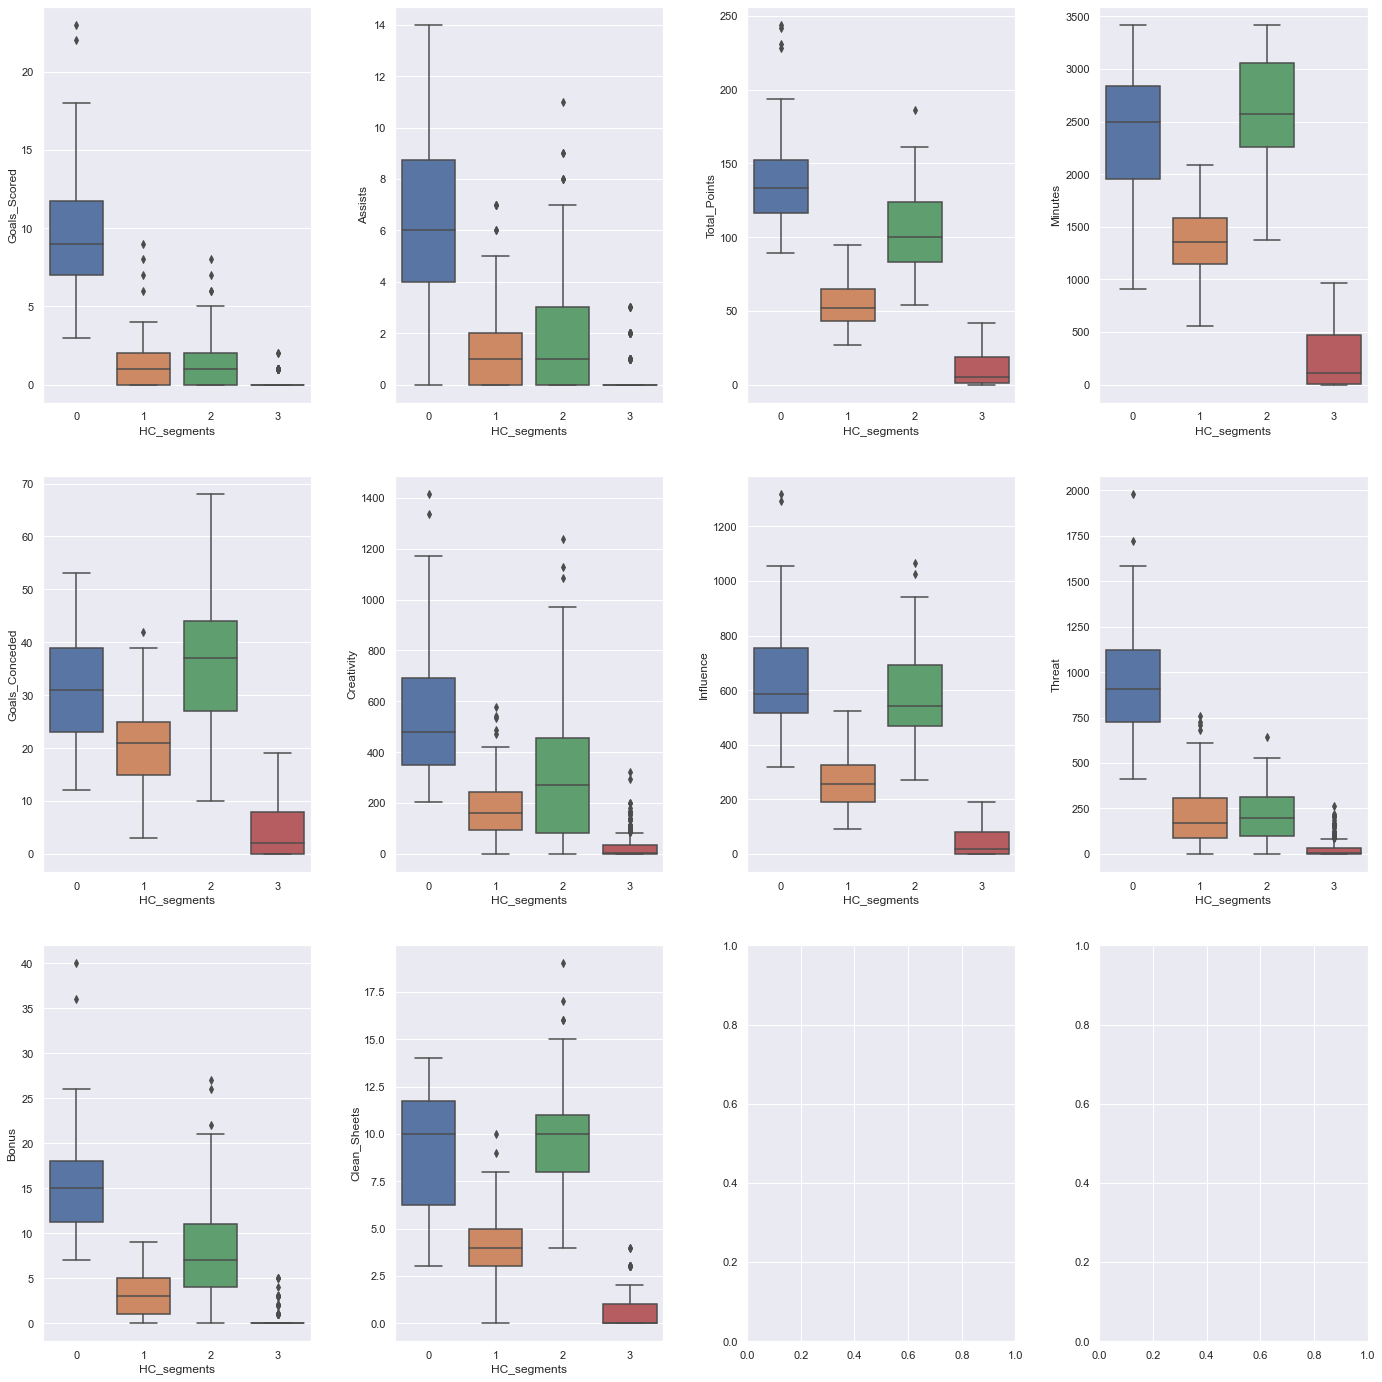

In [72]:
fig, axes = plt.subplots(3, 4, figsize = (20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 10:
            sns.boxplot(
                ax = axes[ii][jj],
                data = df3,
                y = df3.columns[3 + counter],
                x = "HC_segments",
            )
            counter = counter + 1

fig.tight_layout(pad = 3.0)

### **Comparison of cluster profiles from Hierarchical and previous algorithms**


1. There is a difference in the distribution of each cluster with the algorithms. Two clusters in the Agglomerative algorithm are distributed similarly whereas rest two groups are grouped with a low and high range value.

2. The cluster profiles are the same for the algorithms, the only difference lies in the cluster number however cluster profiles remain the same.

### **Characteristics of each cluster**

- **Cluster 0**
    - There are 54 players in this cluster.
    - Most of the players in this cluster have a lot of goals and assists, and the total fantasy points scored in the previous season are high.
    - Most of the players in this cluster had a high game time, high creativity, influence, and scores.
    - Most of the players in this cluster received high bonus points.


- **Cluster 1**
    - There are 114 players in this cluster.
    - Most of the players in this cluster have a few goals and assists and the total fantasy points scored in the previous season are low.
    - Most of the players in this cluster had a moderate game time, a low creativity score, a high influence score, and a moderate threat score.
    - Most of the players in this cluster received low bonus points.


- **Cluster 2**
    - There are 117 players in this cluster.
    - Most of the players in this cluster have a few goals and assists, and the total fantasy points scored in the previous season are moderate.
    - Most of the players in this cluster had a high game time, a moderate creativity score, a high influence score, and a moderate threat score.
    - Most of the players in this cluster received moderate bonus points.


- **Cluster 3**
    - There are 191 players in this cluster.
    - Players in this cluster, except a few, have no goals and assists and did not score any fantasy points scored in the previous season.
    - Most of the players in this cluster had a low game time, and low creativity, influence, and threat scores.
    - Players in this cluster, except a few, received no bonus points.

## **Gaussian Mixture Model (GMM) Clustering**

In [73]:
gmm_df = data_pca.copy()

In [74]:
# Let's apply Gaussian Mixture
gmm = GaussianMixture(n_components = 4, random_state = 1)  # Initializing the Gaussian Mixture algorithm with n_components = 4

gmm.fit(gmm_df)                                            # Fitting the algorithm on the gmm_df data

GaussianMixture(n_components=4, random_state=1)

### **Cluster Profiling**

In [75]:
# Creating a copy of the original data
df4 = df.copy()

# Adding GMM cluster labels to the original and scaled dataframes
gmm_df["GMM_segments"] = gmm.predict(gmm_df)
df4["GMM_segments"] = gmm.predict(data_pca)

In [76]:
gmm_cluster_profile = df4.groupby("GMM_segments").mean()

In [77]:
gmm_cluster_profile["count_in_each_segment"] = (
    df4.groupby("GMM_segments")["Total_Points"].count().values
)


In [78]:
gmm_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,count_in_each_segment
GMM_segments,,,,,,,,,,,
0,1.189655,1.344828,94.439655,2453.189655,33.793103,221.881897,535.862069,174.991379,6.793103,9.431034,116
1,0.000000,0.000000,3.547619,107.436508,2.055556,8.590476,15.739683,5.746032,0.000000,0.182540,126
2,6.552381,5.390476,114.876190,2104.809524,29.619048,501.710476,521.451429,683.466667,11.904762,7.685714,105
3,0.635659,0.868217,34.031008,908.968992,14.186047,106.855039,165.444961,110.813953,1.612403,2.596899,129


In [79]:
# Let's see the names of the players in each cluster
for cl in df4["GMM_segments"].unique():
    print("In cluster {}, the following players are present:".format(cl))
    print(df4[df4["GMM_segments"] == cl]["Player_Name"].unique())
    print()

In cluster 1, the following players are present:
['Alex Runnarsson' 'Matt Macey' 'Miguel Azeez' 'Reiss Nelson'
 'Sead Kolasinac' 'Shkodran Mustafi' 'Sokratis Papastathopoulos'
 'William Saliba' 'Carney Chukwuemeka' 'Henri Lansbury'
 'Jaden Philogene-Bidace' 'Jose Peleteiro Romallo' 'Morgan Sanson'
 'Orjan Nyland' 'Wesley Moraes' 'Bernardo Fernandes da Silva Junior'
 'Davy Propper' 'Jason Steele' 'Jayson Molumby' 'Jose Izquierdo'
 'Reda Khadra' 'Anthony Driscoll-Glennon' 'Bailey Peacock-Farrell'
 'Dale Stephens' 'Joel Mumbongo' 'Josh Benson' 'Lewis Richardson'
 'Phil Bardsley' 'Will Norris' 'Billy Gilmour'
 'Emerson Palmieri dos Santos' 'Faustino Anjorin' 'Fikayo Tomori'
 'Karlo Ziger' 'Valentino Livramento' 'Willy Caballero' 'Connor Wickham'
 'Jack Butland' 'James McCarthy' 'Mamadou Sakho' 'Martin Kelly'
 'Nathan Ferguson' 'Reece Hannam' 'Ryan Inniss' 'Sam Woods'
 'Stephen Henderson' 'Anthony Gordon' 'Cenk Tosun' 'Fabian Delph'
 'Joao Virginia' 'Jonjoe Kenny' 'Joshua King' 'Moise Kean'

In [80]:
df4.groupby(["GMM_segments", "Position"])['Player_Name'].count()

GMM_segments  Position  
0             Defender      64
              Goalkeeper    18
              Midfielder    34
1             Defender      48
              Forward       21
              Goalkeeper    19
              Midfielder    38
2             Defender      10
              Forward       32
              Midfielder    63
3             Defender      50
              Forward       11
              Goalkeeper     8
              Midfielder    60
Name: Player_Name, dtype: int64

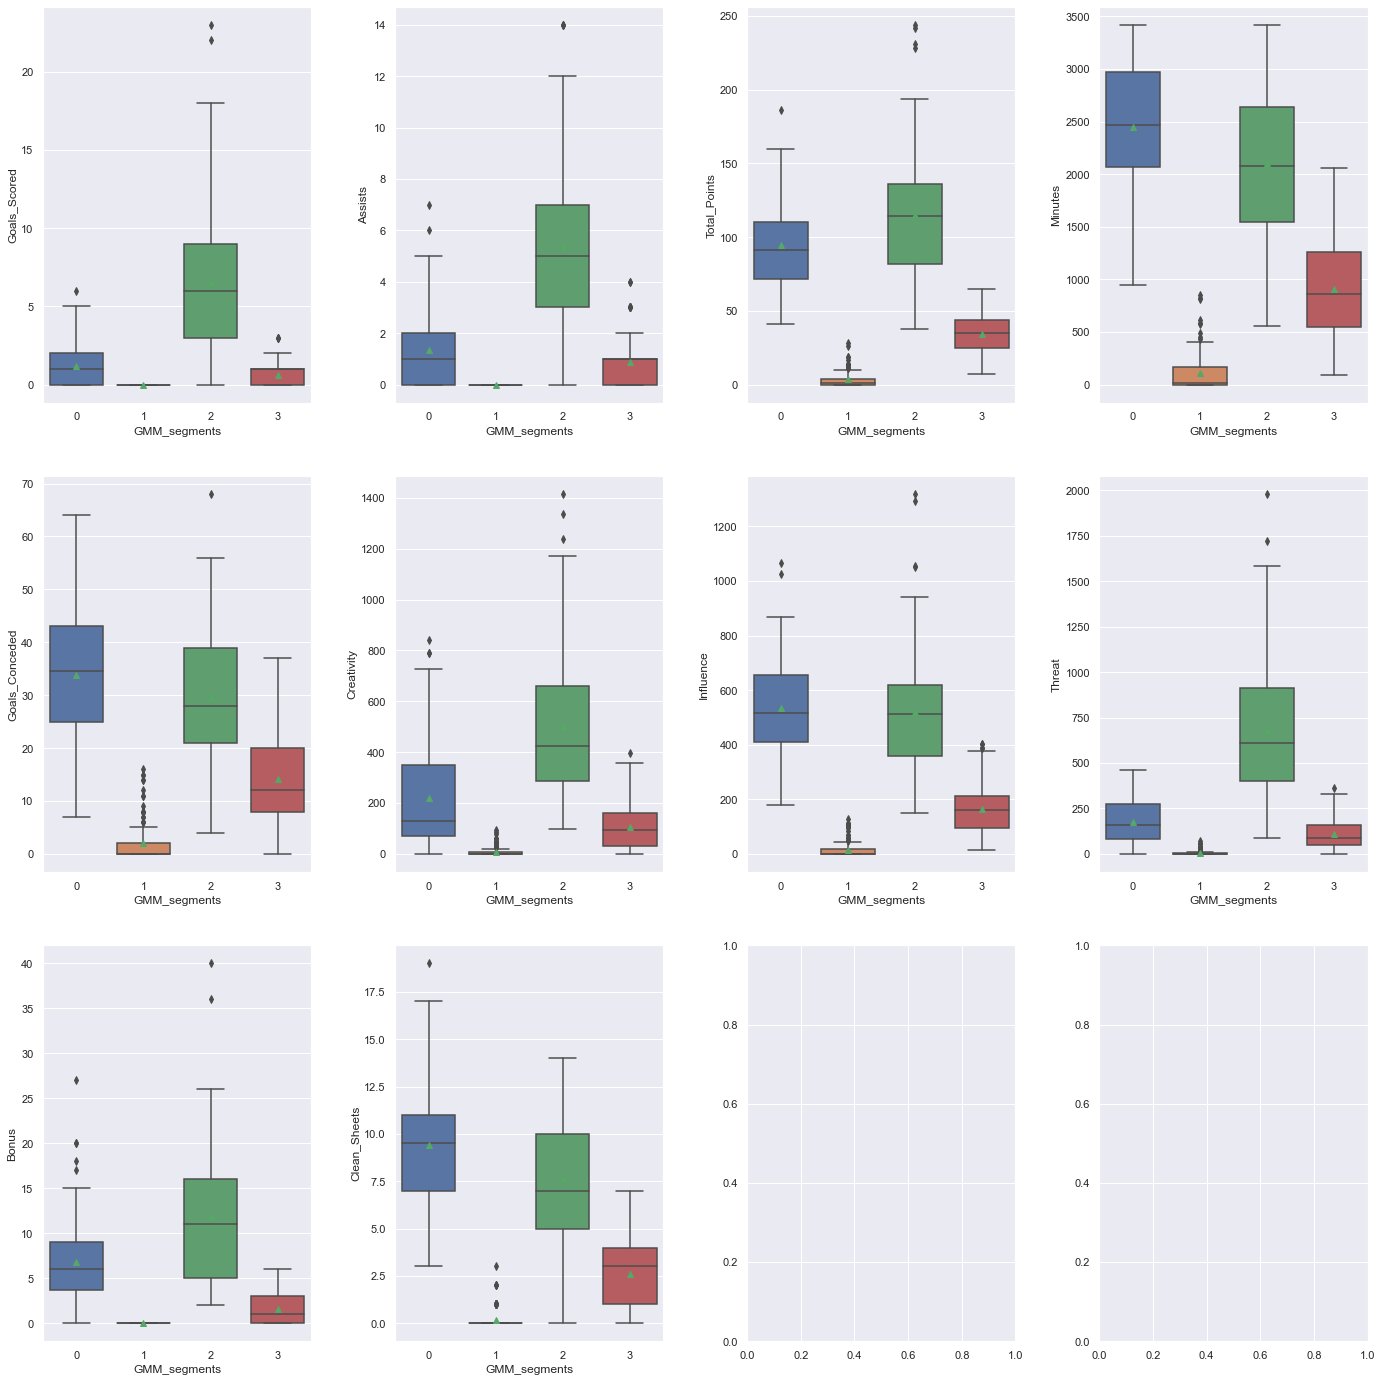

In [81]:
fig, axes = plt.subplots(3, 4, figsize = (20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 10:
            sns.boxplot(
                ax = axes[ii][jj],
                data = df4,
                y = df4.columns[3 + counter],
                x = "GMM_segments",showmeans = True
            )
            counter = counter + 1

fig.tight_layout(pad = 3.0)

### **Comparison of cluster profiles from GMM and previous algorithms**


1. There is a difference in the distribution of each cluster with the other algorithms. Every cluster in GMM is distributed more or less similarly with the same size.

2. The cluster profiles are the same for all the algorithms, the only difference lies in the cluster number however cluster profiles remain the same.

### **Characteristics of each cluster**

- **Cluster 0**
    - There are 116 players in this cluster.
    - Most of the players in this cluster have moderate goals and assists, and the total fantasy points scored in the previous season are moderate.
    - Most of the players in this cluster had a very high game time, high influence, and moderate creativity scores.
    - Most of the players in this cluster received moderate bonus points.
    - Most of the players in this cluster received high clean sheets with an average of 9.43.


- **Cluster 1**
    - There are 126 players in this cluster.
    - The players in this cluster haven't scored goals and assists and the total fantasy points scored in the previous season are very low.
    - Most of the players in this cluster had a very low game time, and very low creativity, influence, and threat scores.
    - The players in this cluster haven't received any bonus points.


- **Cluster 2**
    - There are 105 players in this cluster.
    - Most of the players in this cluster have high goals and assists, and the total fantasy points scored in the previous season are high.
    - Most of the players in this cluster had a high game time, a moderate influence score, a high creativity score, and a moderate threat score.
    - Most of the players in this cluster received the highest bonus points.


- **Cluster 3**
    - There are 129 players in this cluster.
    - Most of the players in this cluster have a few goals and assists, and the total fantasy points scored in the previous season are low.
    - Most of the players in this cluster had moderate game time, low creativity, influence, and threat scores.
    - Most of the players in this cluster received low bonus points.

## **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

In [82]:
dbscan_df = data_pca.copy()

In [83]:
# Initializing lists
eps_value = [2,3]           # Taking random eps value
min_sample_values = [6,20]  # Taking random min_sample value

# Creating a dictionary for each of the values in eps_value with min_sample_values
res = {eps_value[i]: min_sample_values for i in range(len(eps_value))}  

In [84]:
# Finding the silhouette_score for each of the combination

high_silhouette_avg = 0                                               # Assigning 0 to the high_silhouette_avg variable
high_i_j = [0, 0]                                                     # Assigning 0's to the high_i_j list
key = res.keys()                                                      # Assigning dictionary keys to a variable called key
for i in key:
    z = res[i]                                                        # Assigning dictionary values of each i to z
    for j in z:
        db = DBSCAN(eps = i, min_samples = j).fit(dbscan_df)          # Applying DBSCAN to each of the combinations in dictionary
        core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        silhouette_avg = silhouette_score(dbscan_df, labels)          # Finding silhouette score 
        print( 
            "For eps value =" + str(i),
            "For min sample =" + str(j),
            "The average silhoutte_score is :",
            silhouette_avg,                                          # Printing the silhouette score for each of the combination
        )
        if high_silhouette_avg < silhouette_avg:                     # If the silhouette score is greater than 0 or the previous score, it will get appended to the high_silhouette_avg list with its combination of i and j              
            high_i_j[0] = i
            high_i_j[1] = j

For eps value =2 For min sample =6 The average silhoutte_score is : 0.528300891282389
For eps value =2 For min sample =20 The average silhoutte_score is : 0.36478187516967586
For eps value =3 For min sample =6 The average silhoutte_score is : 0.6242051898558513
For eps value =3 For min sample =20 The average silhoutte_score is : 0.6188492416303979


In [85]:
# Printing the highest silhouette score
print(
    "Highest_silhoutte_avg is {} for eps = {} and min sample = {}".format(
        high_silhouette_avg, high_i_j[0], high_i_j[1]
    )
)

Highest_silhoutte_avg is 0 for eps = 3 and min sample = 20


In [86]:
# Applying DBSCAN with eps as 3 and min sample as 20
dbs = DBSCAN(eps = 3, min_samples = 20)

In [87]:
# Creating a copy of the original data
df5 = df.copy()

# Add DBSCAN cluster labels to dbscan data
dbscan_df["db_segments"] = dbs.fit_predict(dbscan_df)

# Add DBSCAN cluster labels to whole data
df5["db_segments"] =  dbs.fit_predict(dbscan_df)

In [88]:
db_cluster_profile = df5.groupby("db_segments").mean()

In [89]:
db_cluster_profile["count_in_each_segment"] = (
    df5.groupby("db_segments")["Total_Points"].count().values
)

In [90]:
db_cluster_profile.style.highlight_max(color = "lightgreen", axis = 0)

,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,count_in_each_segment
db_segments,,,,,,,,,,,
-1,18.666667,11.666667,221.000000,3045.000000,41.000000,779.533333,1067.566667,1447.000000,28.666667,11.166667,6
0,1.693617,1.625532,56.442553,1315.104255,18.878723,188.526383,284.750213,209.361702,4.412766,4.663830,470


**Observations:**

- DBSCAN was able to give only two clusters with eps = 3 and min_sample = 20 which is very skewed.  
- It is not able to perform well on this dataset.

### **Choosing the Best Algorithm**

- Since cluster profiles are the same for every algorithm except DBSCAN, it is difficult to choose the best algorithm. The silhouette score was computed to choose the best algorithm among all the algorithms.

In [91]:
kmeans = KMeans(n_clusters = 4, random_state = 1)        # Initializing K-Means with number of clusters as 4 and random_state=1

preds = kmeans.fit_predict((data_pca))                   # Fitting and predicting K-Means on data_pca

score = silhouette_score(data_pca, preds)                # Calculating the silhouette score

print(score)         

0.4041321364385189


In [92]:
kmedoids = KMedoids(n_clusters = 4, random_state = 1)   # Initializing K-Medoids with number of clusters as 4 and random_state=1

preds = kmedoids.fit_predict((data_pca))                # Fitting and predicting K-Medoids on data_pca

score = silhouette_score(data_pca, preds)               # Calculating the silhouette score

print(score)   

0.3938224996935734


In [93]:
# Initializing Agglomerative Clustering with distance as Euclidean, linkage as ward with clusters = 4
HCmodel = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward",) 

# Fitting on PCA data
preds = HCmodel.fit_predict(data_pca)  

score = silhouette_score(data_pca, preds)             # Calculating the silhouette score

print(score)   

0.3849709986025471


In [94]:
# Initializing Gaussian Mixture algorithm with number of clusters as 4 and random_state = 1
gmm = GaussianMixture(n_components=4, random_state=1)   

# Fitting and predicting Gaussian Mixture algorithm on data_pca
preds = gmm.fit_predict((data_pca))

# Calculating the silhouette score
score = silhouette_score(data_pca, preds)

# Printing the score
print(score)

0.28494644297302235


- Based on the silhouette score, we can see that K-Means algorithm giving the best score on the data. We would proceed K-Means as the best algorithm.

## **Conclusion:**

- The players who have a greater influence on the outcome of the game typically play for a longer duration every game and score more fantasy points.
- The players can be sold for more money who have higher goals scored, creativity, and influence.
- Since there is a drop at K = 4 in the elbow plot, we selected K as 4 for clustering.
- We implemented five algorithms, but we have chosen K-Means algorithm as the final algorithm because it has the highest silhouette score of 0.40.


## **Recommendations:**

- **Cluster 0** players are the top players for fantasy. They fetch more points and have a higher chance of getting bonus points too. These players should be priced higher than the others so that it will be difficult to accommodate too many of them in the same team (because of the fixed budget) and fantasy managers have to make wise choices.


- **Cluster 1** players are players who do not play many minutes, most likely come on as substitutes and fetch lesser fantasy points as a result. These players should be priced low and can be good differential picks.


- **Cluster 2** are the players who are influential in their team's play but do not tend to score or assist much, resulting in lesser fantasy points than the Cluster 0 players. These players should be priced somewhere between Cluster 0 and Cluster 1 players.


- **Cluster 3** has the players who are in the squad to provide backup in case any of the starting 11 players get injured. They get lower game time and barely get any fantasy points. These players should be priced the lowest among the 4 clusters.


- Player performances from previous seasons should be taken into account and fantasy prices from the previous season should be referred to as a benchmark to determine the price for the upcoming season.


- OnSports should conduct cluster analysis separately for each of the playing positions to arrive at a better fantasy pricing strategy.